In [34]:
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

# Exploring Tweets

## Reading in Scraped Tweets

Tweets were scraped using Twint, ran in the Command Line.

Example script: twint -u lexfridman -o lexfridman.csv --csv

In [4]:
df = pd.read_csv('Scraped-Tweets/lex.csv', sep='	')
df = df[['date', 'name', 'tweet', 'hashtags']]

In [5]:
df.head()

,date,name,tweet,hashtags
0,2021-01-22,Lex Fridman,"I was on @joerogan's podcast yesterday, and ha...",[]
1,2021-01-21,Lex Fridman,I'm running 48 miles in 48 hours with @davidgo...,[]
2,2021-01-20,Lex Fridman,I have hope for 2021. Let's make this year ama...,[]
3,2021-01-20,Lex Fridman,"""Every moment is a fresh beginning."" – T.S. Eliot",[]
4,2021-01-20,Lex Fridman,I hope everyone stays safe out there today.,[]


In [6]:
df.isnull().sum()

date        0
name        0
tweet       0
hashtags    0
dtype: int64

In [7]:
df.hashtags.value_counts()

[]                             1116
['masks4all']                     3
['yanggang']                      3
['chi2018']                       2
['yanggang', 'stranggang']        1
['devs']                          1
['soldoutshow']                   1
['chi2017']                       1
['neurips2018', 'nips2018']       1
['gtc19']                         1
Name: hashtags, dtype: int64

In [8]:
# Removing adam grant as he has lots of personal stuff
path = 'Scraped-Tweets/'
names = ['conan', 'brenebrown', 'timsid', 'lex',
            'dalailama', 'pourmecoffee', 'simonsinek', 'stevemartin']
dfs = {}

for name in names:
    dfs[name] = pd.read_csv(path + name + '.csv', sep= '	')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [156]:
dfs['conan'][0:5]

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1352711131312381953,1352711131312381953,2021-01-22 14:14:00 CST,2021-01-22,14:14:00,-600,115485051,conanobrien,Conan O'Brien,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1352377939762032649,1352377939762032649,2021-01-21 16:10:01 CST,2021-01-21,16:10:01,-600,115485051,conanobrien,Conan O'Brien,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1351954900075294720,1351954900075294720,2021-01-20 12:09:00 CST,2021-01-20,12:09:00,-600,115485051,conanobrien,Conan O'Brien,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1351608107118571520,1351608107118571520,2021-01-19 13:10:59 CST,2021-01-19,13:10:59,-600,115485051,conanobrien,Conan O'Brien,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1351291278080749569,1351291278080749569,2021-01-18 16:12:01 CST,2021-01-18,16:12:01,-600,115485051,conanobrien,Conan O'Brien,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [10]:
df_to_rule_them_all = pd.concat(dfs.values(), ignore_index=True)

In [11]:
tweets = df_to_rule_them_all[['date', 'name', 'tweet', 'hashtags']]

In [12]:
tweets.name.value_counts()

pourmecoffee     29400
Tim Siedell      16858
Brené Brown      10985
Conan O'Brien     4392
Simon Sinek       3263
Dalai Lama        1404
Lex Fridman       1130
Steve Martin       526
Name: name, dtype: int64

In [13]:
tweets.tweet.isnull().any()

False

In [14]:
tweets.hashtags.value_counts()

[]                                                65262
['supersoulsunday']                                  88
['olcbrenecourse']                                   48
['lifeclass']                                        39
['lifeclass', 'daring']                              35
                                                  ...  
['thegiftsofimperfections', '10thanniversary']        1
['changethesystem']                                   1
['nothappy']                                          1
['noshame', 'hard', 'supersoulsunday']                1
['gearsofwar4']                                       1
Name: hashtags, Length: 1586, dtype: int64

In [15]:
# lol Oprah showing out

### Cleaning Tweets

Different methods were tested for cleaning tweets. Ultimately, we went with removing URLs and emojis and selecting tweets longer than 30 characters. Additional processing to remove tweets starting with a mention was done after training the initial language model.

Note: Adam Grant was removed since many of his tweets were personal... and many were about drinking in Toronto haha

In [16]:
# def remove_url(txt):
#     return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
# tweets['tweet_stripped'] = [remove_url(tweet) for tweet in tweets['tweet']]
# tweets['tweet_stripped'][:5]

In [17]:
# tweets['tweet_stripped'][4000:4005]

In [18]:
# def remove_mentions(txt):
#     return " ".join(re.sub("@[A-Za-z0-9]+","", txt).split())
# tweets['tweet_stripped'] = [remove_mentions(tweet) for tweet in tweets['tweet']]
# tweets['tweet_stripped'][:5]

In [19]:
import preprocessor as p
# Tweet preprocesser, set to remove emojis and urls, leave in hashtags
p.set_options(p.OPT.URL, p.OPT.EMOJI)

In [20]:
tweets['tweet_clean'] = tweets['tweet'].map(p.clean)

<ipython-input-20-27b52d49b298>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['tweet_clean'] = tweets['tweet'].map(p.clean)


In [21]:
tweets['tweet_clean'][118:125]

118    ATTN. People who live in Wisconsin: Not regist...
119    Which doctor has to tell him he caught the vir...
120    Looks like Mike Pence has locked up the white ...
121    Im sorry, but how can dogs play at a time like...
122    My favorite game to play these days is guessin...
123                 Good luck getting paid, Walter Reed.
124    The last time North Carolina citizens didn't v...
Name: tweet_clean, dtype: object

In [22]:
# tweets['tweet_stripped'][118:125]

Limiting tweets to longer than 30 characters - removed just over 10,000 tweets (or rows)

In [23]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67958 entries, 0 to 67957
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         67958 non-null  object
 1   name         67958 non-null  object
 2   tweet        67958 non-null  object
 3   hashtags     67958 non-null  object
 4   tweet_clean  67958 non-null  object
dtypes: object(5)
memory usage: 2.6+ MB


In [24]:
mask = (tweets['tweet_clean'].str.len() > 30)
tweets = tweets.loc[mask]

In [25]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57813 entries, 0 to 67957
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         57813 non-null  object
 1   name         57813 non-null  object
 2   tweet        57813 non-null  object
 3   hashtags     57813 non-null  object
 4   tweet_clean  57813 non-null  object
dtypes: object(5)
memory usage: 2.6+ MB


In [26]:
tweets['tweet_clean']

0        After Covid, people with soul patches should s...
1        Ill never get used to having a First Lady who ...
2        6.8 miles below the sea is the Marianas Trench...
3        Im looking forward to sweating the small stuff...
4        Easy compromise: Lower the maximum wage to $15...
                               ...                        
67952    When the audience stays the whole show, we kno...
67953    Great audience last night makes us even more i...
67955    Congratulations to Kristin Scott Benson on bei...
67956    @cpaitsel @GarryShandling Great analogy. Just ...
67957                    @SteveAllen95 Still am. In Omaha.
Name: tweet_clean, Length: 57813, dtype: object

In [195]:
# tweets.to_csv('all_tweets_full.csv', sep=' ', index=False)

In [196]:
# txt = tweets['tweet_clean']

In [197]:
# txt.to_csv('all_tweets_cleaned.txt', sep=' ', index=False)

In [198]:
# txt.to_csv('all_tweets_cleaned.csv', sep=' ', index=False)

### Removing Tweets Beginning with @

In [27]:
trim = pd.read_csv('Data/all_tweets_cleaned.csv', sep=' ')

In [28]:
trim.head()

,tweet_clean
0,"After Covid, people with soul patches should s..."
1,Ill never get used to having a First Lady who ...
2,6.8 miles below the sea is the Marianas Trench...
3,Im looking forward to sweating the small stuff...
4,Easy compromise: Lower the maximum wage to $15...


In [29]:
trim['new_col'] = trim[trim['tweet_clean'].astype(str).str[0] != '@']

In [30]:
trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57813 entries, 0 to 57812
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  57813 non-null  object
 1   new_col      40985 non-null  object
dtypes: object(2)
memory usage: 903.5+ KB


In [31]:
# Looks like just under 17,000 tweets start with a mention
# May be worth retraining a model that doesn't begin tweets with '@'
# since the model is currently getting stuck at creating mentions or replies
trim['new_col']

0        After Covid, people with soul patches should s...
1        Ill never get used to having a First Lady who ...
2        6.8 miles below the sea is the Marianas Trench...
3        Im looking forward to sweating the small stuff...
4        Easy compromise: Lower the maximum wage to $15...
                               ...                        
57808    When the audience stays the whole show, we kno...
57809    Great audience last night makes us even more i...
57810    Congratulations to Kristin Scott Benson on bei...
57811                                                  NaN
57812                                                  NaN
Name: new_col, Length: 57813, dtype: object

In [32]:
trim['tweet_nom'] = trim['new_col'].dropna()

In [33]:
trim.dropna(inplace=True)

In [34]:
trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40985 entries, 0 to 57810
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  40985 non-null  object
 1   new_col      40985 non-null  object
 2   tweet_nom    40985 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [35]:
txt_nom = trim['tweet_nom']

In [212]:
# txt_nom.to_csv('all_tweets_nom.csv', sep=' ', index=False)

## EDA Time --> Visuals (￣▽￣)ノ

### Real Tweets

In [37]:
import seaborn as sns
sns.set_style("darkgrid")

In [538]:
tweets = pd.read_csv('Data/all_tweets_full.csv', sep=' ')

In [539]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57813 entries, 0 to 57812
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         57813 non-null  object
 1   name         57813 non-null  object
 2   tweet        57813 non-null  object
 3   hashtags     57813 non-null  object
 4   tweet_clean  57813 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [540]:
tweets['name'].value_counts()

pourmecoffee     23703
Tim Siedell      14766
Brené Brown      9063 
Conan O'Brien    4342 
Simon Sinek      3062 
Dalai Lama       1401 
Lex Fridman      1073 
Steve Martin     403  
Name: name, dtype: int64

#### Account Contributors Plot

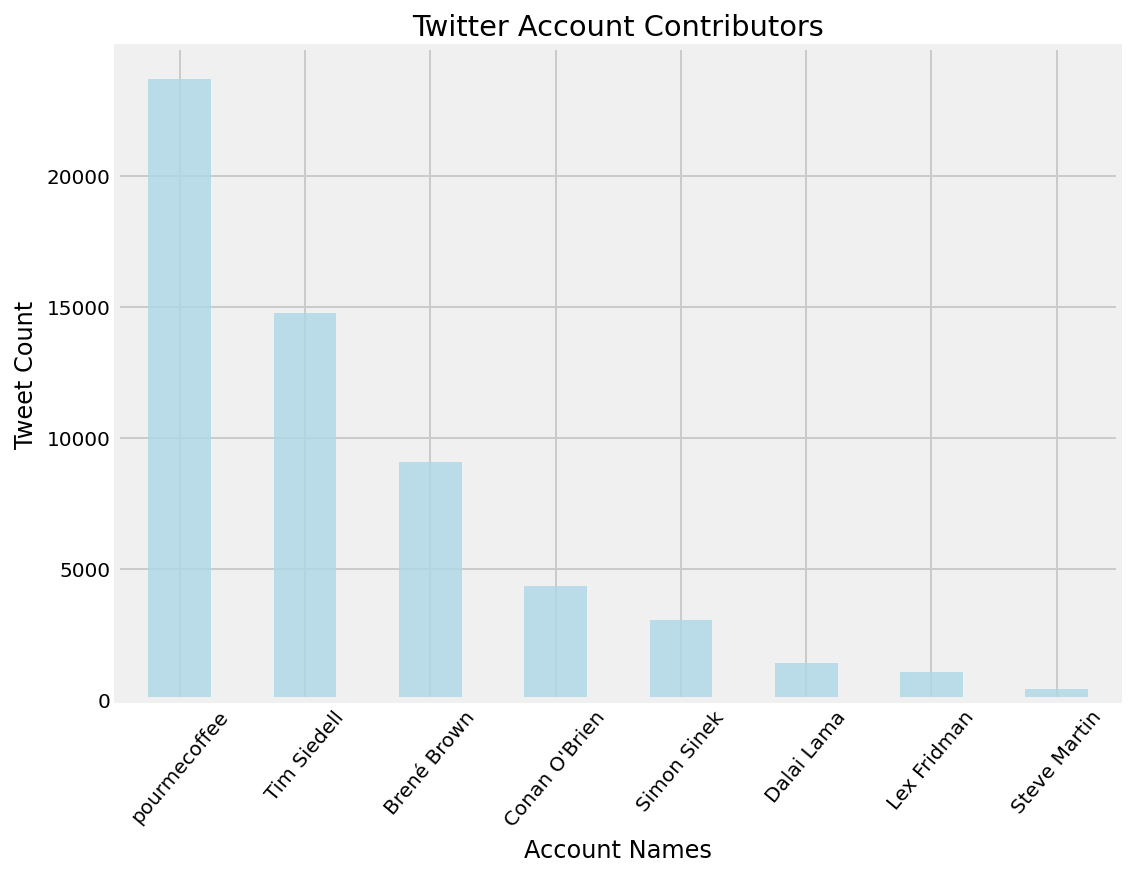

In [545]:
tweets.name.value_counts(normalize=False).plot(kind='bar', figsize=(8, 6),
                                             color='Lightblue', alpha=0.8, title='Twitter Account Contributors',
                                              xlabel='Account Names', ylabel='Tweet Count')
plt.xticks(rotation=50);

In [42]:
tweets['date'] = pd.to_datetime(tweets['date'])

In [43]:
tweets['count'] = 1

In [44]:
daily_counts = tweets.groupby(by=['date']).count()

#### Tweets Per Day Plot

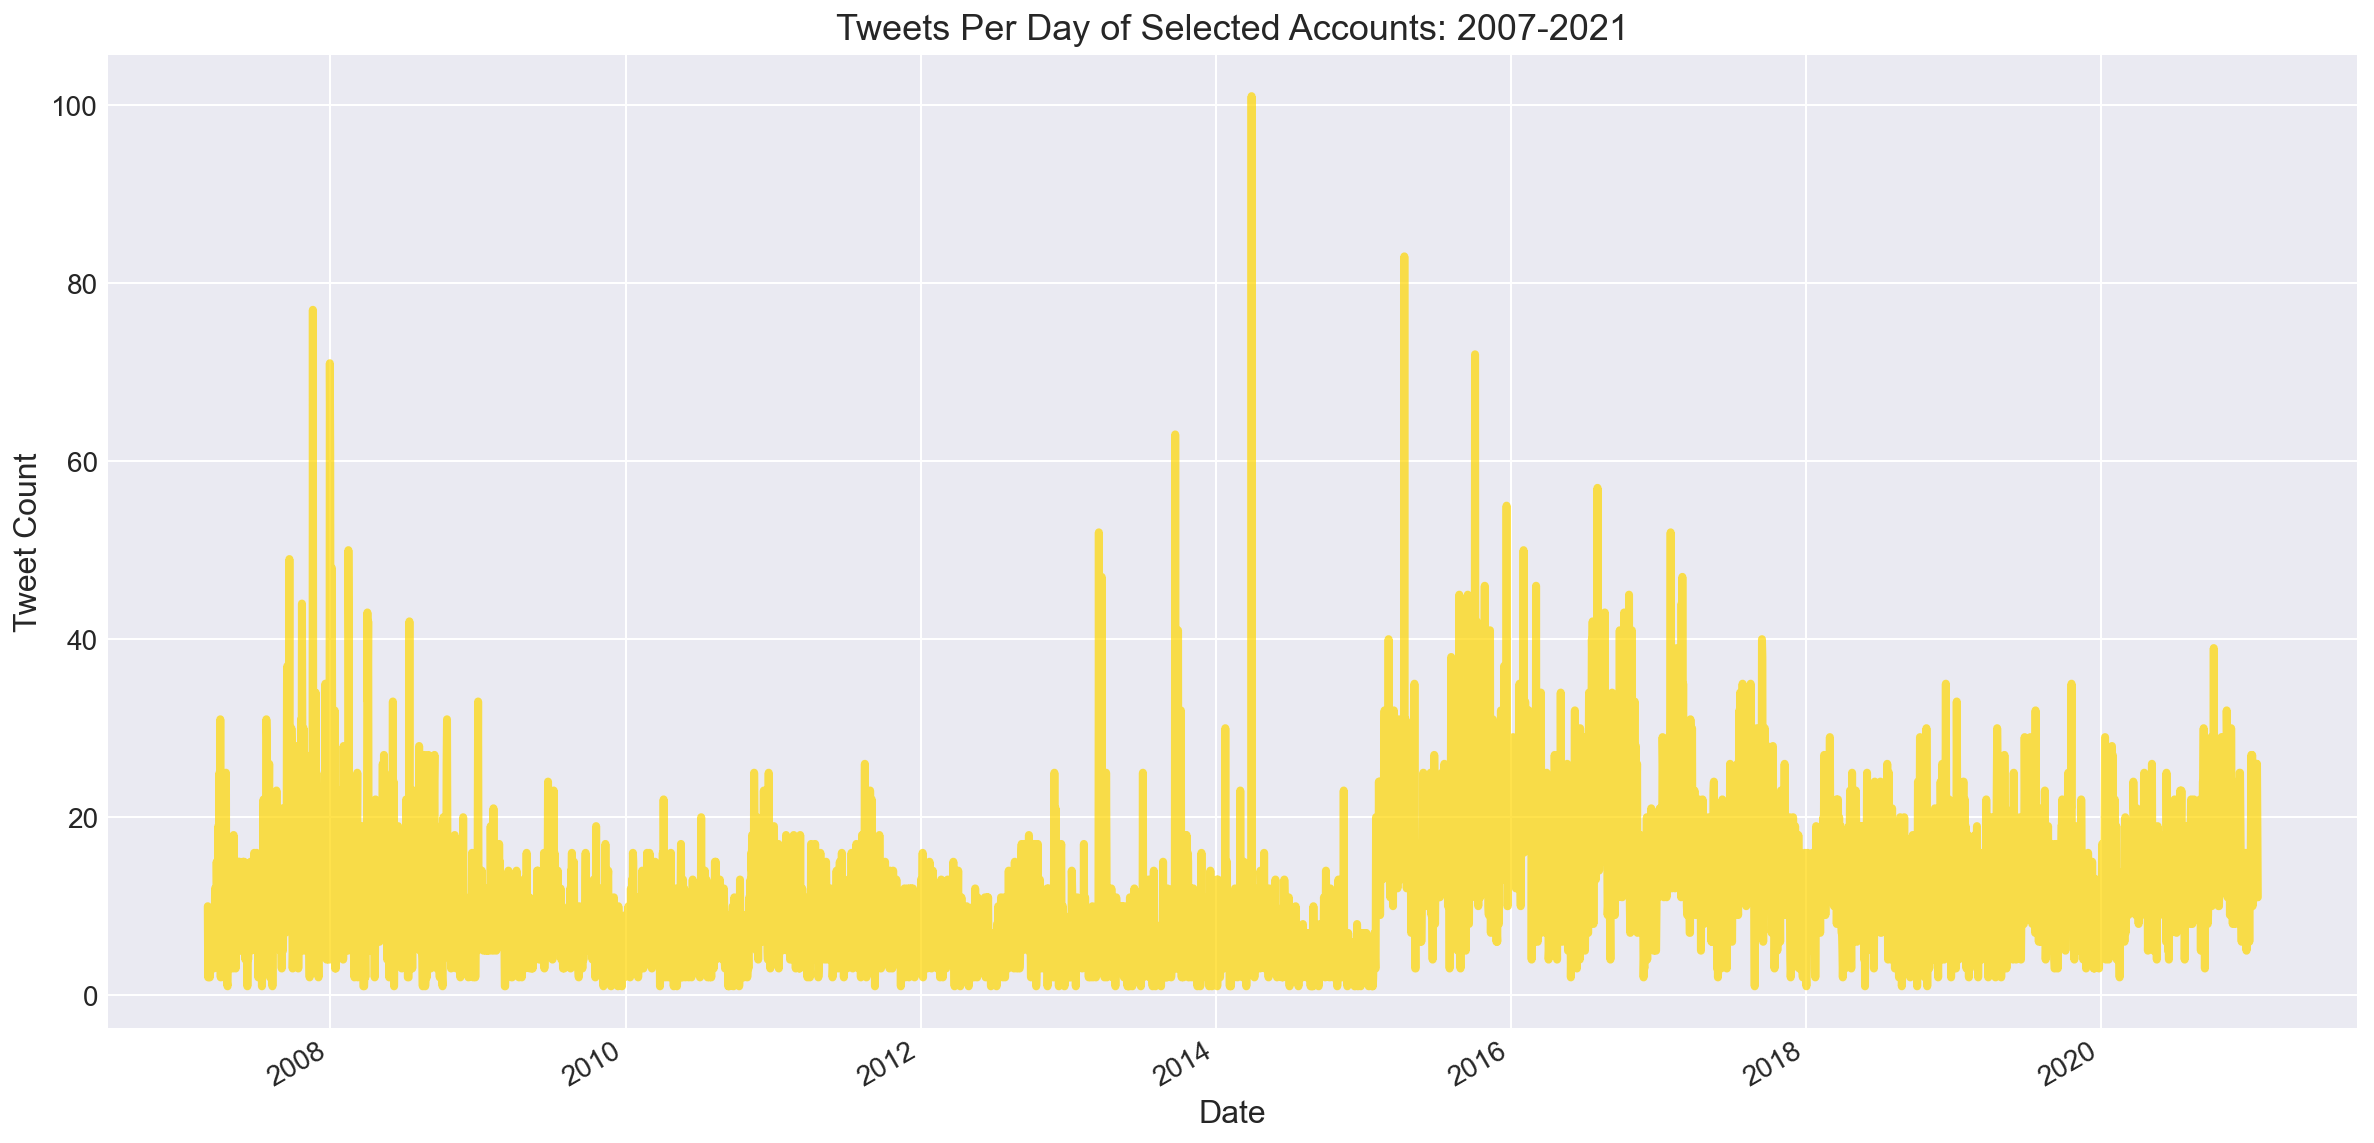

In [46]:
daily_counts['count'].plot(ylabel='Tweet Count', fontsize=14, figsize=(18,10), color='gold', alpha=0.7)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Tweet Count', fontsize=16)
plt.title('Tweets Per Day of Selected Accounts: 2007-2021', fontsize=18);


In [107]:
tweets['length'] = tweets.tweet_clean.apply(len)

#### Tweet Length by Account Plot

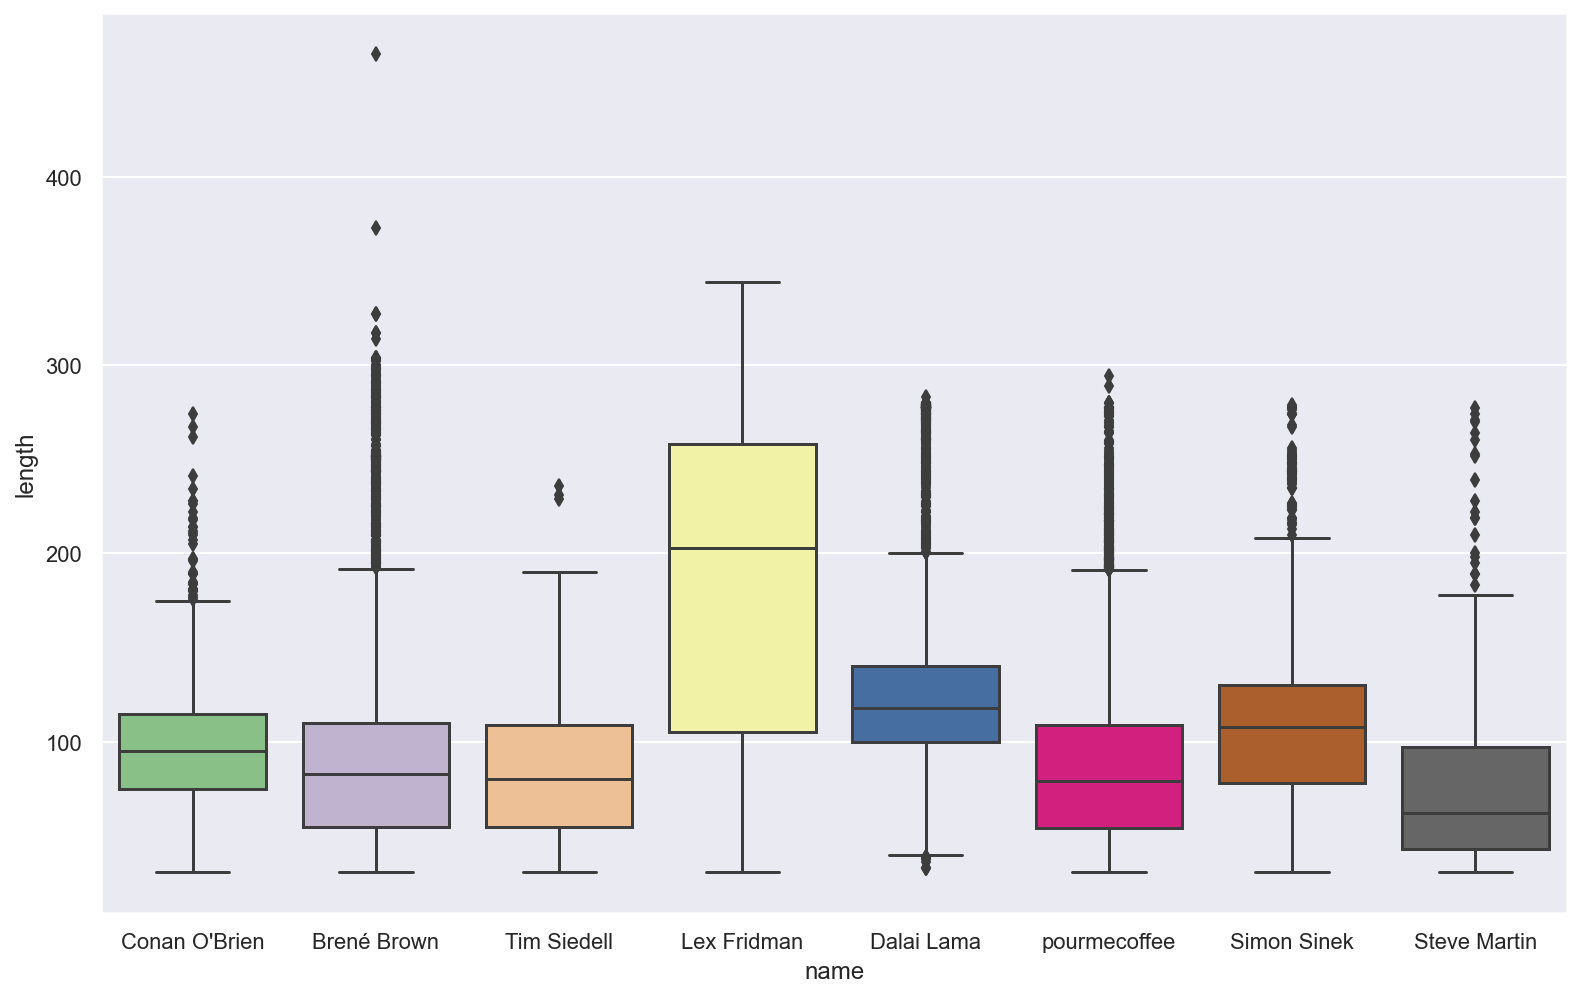

In [48]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="name", y="length", data=tweets, palette='Accent')


#### Text Processing

In [378]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [219]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [220]:
# import en_core_web_sm
# nlp = en_core_web_sm.load()

# # lemma_word1 = [] 
# # for token in doc:
# #     lemma_word1.append(token.lemma_)
# # print(lemma_word1)

# def lemma(article):
#     tokens = nltk.word_tokenize(article)  
#     lemmed = [token.lower().lemma_ for token in tokens if token.lower() not in stopwords_list]
#     return lemmed

In [221]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [222]:
stopwords = stopwords.words('english') + list(string.punctuation)
stopwords += ["''", '""', '...', '``', 'im', '\ufeff1', "'s", "n't", 'https', 'http', 'amp']

In [223]:
stopwords = set(stopwords_list)

In [224]:
def cleaner(df, series):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df[series].str.findall(pattern).str.join(' ')
    limit = len(df)
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

In [225]:
df_preproc = cleaner(tweets, 'tweet')
print(df_preproc.info())
df_preproc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57813 entries, 0 to 57812
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         57813 non-null  object
 1   name         57813 non-null  object
 2   tweet        57813 non-null  object
 3   hashtags     57813 non-null  object
 4   tweet_clean  57813 non-null  object
 5   length       57813 non-null  int64 
 6   clean        57813 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB
None


,date,name,tweet,hashtags,tweet_clean,length,clean
0,2021-01-22,Conan O'Brien,"After Covid, people with soul patches should still have to wear a mask.",[],"After Covid, people with soul patches should still have to wear a mask.",71,After Covid people with soul patches should still have wear mask
1,2021-01-21,Conan O'Brien,I’ll never get used to having a First Lady who is not from Slovenia,[],Ill never get used to having a First Lady who is not from Slovenia,66,never get used having First Lady who not from Slovenia
2,2021-01-20,Conan O'Brien,"6.8 miles below the sea is the Marianas Trench, and 6.8 miles below that is the bar Trump set for Biden.",[],"6.8 miles below the sea is the Marianas Trench, and 6.8 miles below that is the bar Trump set for Biden.",104,miles below the sea the Marianas Trench and miles below that the bar Trump set for Biden
3,2021-01-19,Conan O'Brien,I’m looking forward to sweating the small stuff again.,[],Im looking forward to sweating the small stuff again.,53,looking forward sweating the small stuff again
4,2021-01-18,Conan O'Brien,Easy compromise: Lower the maximum wage to $15/hour.,[],Easy compromise: Lower the maximum wage to $15/hour.,52,Easy compromise Lower the maximum wage hour


In [226]:
def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords] 
    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

In [227]:
%%time
df_preproc['preproc_pipe'] = preprocess_pipe(df_preproc['clean'])
df_preproc[['date', 'name', 'tweet', 'preproc_pipe']].head(3)

CPU times: user 11.8 s, sys: 173 ms, total: 12 s
Wall time: 12.1 s


,date,name,tweet,preproc_pipe
0,2021-01-22,Conan O'Brien,"After Covid, people with soul patches should still have to wear a mask.","[covid, people, soul, patch, still, wear, mask]"
1,2021-01-21,Conan O'Brien,I’ll never get used to having a First Lady who is not from Slovenia,"[never, get, use, first, lady, slovenia]"
2,2021-01-20,Conan O'Brien,"6.8 miles below the sea is the Marianas Trench, and 6.8 miles below that is the bar Trump set for Biden.","[mile, sea, marianas, trench, mile, bar, trump, set, biden]"


In [228]:
df_preproc.preproc_pipe[0:10]

0    [covid, people, soul, patch, still, wear, mask]                                                                   
1    [never, get, use, first, lady, slovenia]                                                                          
2    [mile, sea, marianas, trench, mile, bar, trump, set, biden]                                                       
3    [look, forward, sweat, small, stuff]                                                                              
4    [easy, compromise, lower, maximum, wage, hour]                                                                    
5    [come, anthonyanderson, incredible, michael, jordan, story, stay, surprise, deoncole, cameo, listen, https, https]
6    [great, thing, xylophone]                                                                                         
7    [humiliate, trump, impeachment, finally, exit, white, house, instead, helicopter, send, kia, soul]                
8    [want, use, word, orwellian, tweet,

In [229]:
df_preproc.preproc_pipe[0][0]

'covid'

In [230]:
df_preproc.to_csv('Data/tweets_preprocessed.csv', index=False)

In [257]:
total_vocab = []

for tweet in df_preproc.preproc_pipe:
    for word in tweet:
        total_vocab.append(word)
print(len(total_vocab))
print(len(set(total_vocab)))

516230
43374


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [258]:
tweets_concat = []
for tweet in df_preproc.preproc_pipe:
    for word in tweet:
        tweets_concat.append(word)
print(tweets_concat[0:5])
len(tweets_concat)

['covid', 'people', 'soul', 'patch', 'still']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


516230

In [259]:
stopwords_list += ["'s", "n't", "like", "'m", "get", "'re", "day", "going", "good", 'something', 'look'
                   "new", "would", "today", 'today', 'would', 'one', '’', 'thank', 'back', 'go', 'make',
                   'want', 'right', 'know', 'see', 'way', 'really', 'let', 'first', 'say', 'rt', 'could',
                   'ca', "'ll", 'much', 'never', "'ve", 'take', 'every', 'got', 'man', 'year', 'yes', 'even',
                   'twitter', 'still', 'amp', 'thing', 'everyone', 'guy', 'im', 'talk', 'last', 'show', 
                   'look', 'made', 'need', 'also', 'two', 'book', 'https', 'http', 'well', 'come', 'little', 'watch',
                   'new', 'use', 'call', 'tweet', 'read', 'may', 'great', '\ufeff1', 'try', 'old', 'big', 'com',
                   'long', 'night', 'week', 'mean', 'keep', 'ask', 'name', 'lot', 'tonight', 'hard', 'always', 'sure',
                   'someone', 'ever', 'meet', 'stop', 'post', 'movie', 'eat', 'put', 'wait']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [260]:
tweets_nostops = [word for word in tweets_concat if word not in stopwords_list]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
tweets_dist = FreqDist(tweets_nostops)
tweets_dist.most_common(32)

[('love', 2490),
 ('think', 2398),
 ('time', 2349),
 ('people', 2119),
 ('work', 1730),
 ('realdonaldtrump', 1683),
 ('trump', 1648),
 ('world', 1128),
 ('give', 1060),
 ('live', 1038),
 ('life', 958),
 ('bite', 945),
 ('thanks', 926),
 ('tell', 918),
 ('feel', 906),
 ('find', 898),
 ('start', 851),
 ('help', 761),
 ('hope', 723),
 ('idea', 716),
 ('friend', 706),
 ('fun', 682),
 ('hear', 663),
 ('play', 663),
 ('human', 644),
 ('story', 624),
 ('change', 605),
 ('happy', 597),
 ('mind', 575),
 ('please', 571),
 ('president', 568),
 ('learn', 554)]

#### Most Frequent Words Plot

In [428]:
twords.head(2)

,Top_Words
think,233
love,182


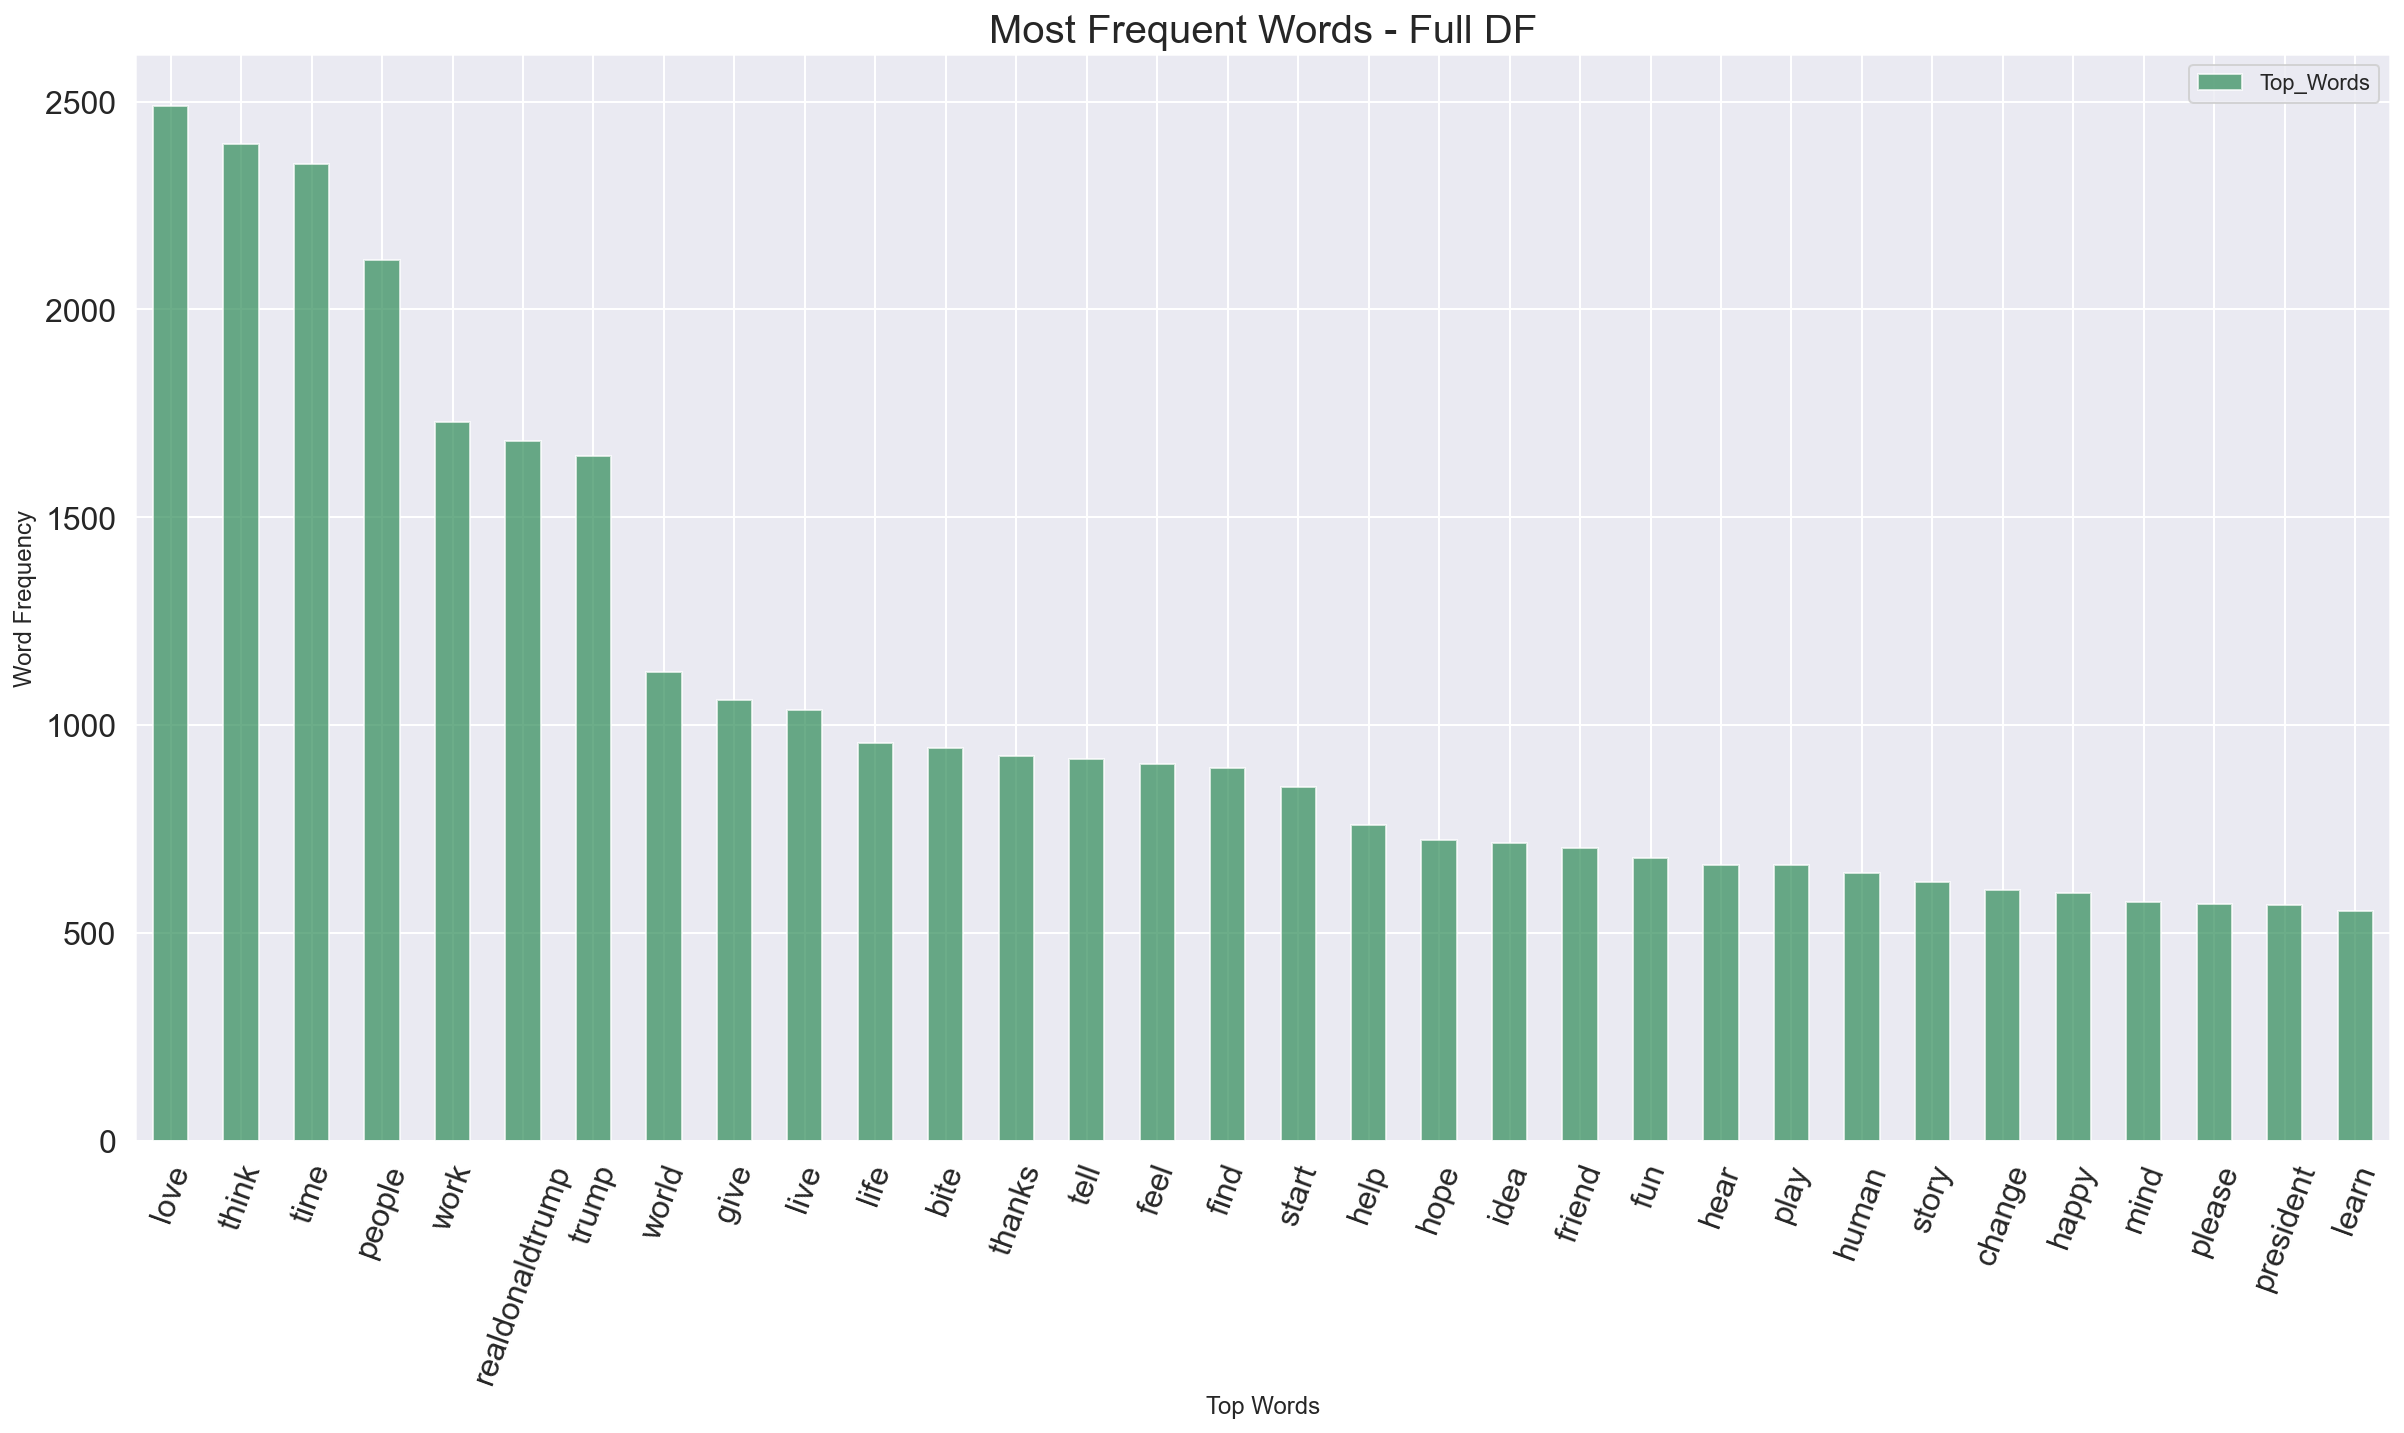

In [66]:
top_words = tweets_dist.most_common(32)

x_val = [x[0] for x in top_words]
y_val = [x[1] for x in top_words]

twords = pd.DataFrame(y_val, index=x_val, columns =['Top_Words'])

twords.plot(kind='bar', alpha=0.7, color='seagreen', figsize=(18,10), fontsize=16)
plt.xlabel('Top Words')
plt.ylabel('Word Frequency')
plt.title('Most Frequent Words - Full DF', fontsize=20)
plt.xticks(rotation=70)
plt.show()

In [400]:
from textblob import TextBlob

In [496]:
polarity = (lambda x: TextBlob(x).sentiment.polarity)
subjectivity = (lambda x: TextBlob(x).sentiment.subjectivity)
df_preproc['polarity'] = df_preproc['tweet_clean'].apply(polarity)
df_preproc['subjectivity'] = df_preproc['tweet_clean'].apply(subjectivity)

In [498]:
df_preproc[['polarity', 'subjectivity']][0:5]

,polarity,subjectivity
0,0.000000,0.000000
1,-0.125000,0.666667
2,0.000000,0.000000
3,-0.250000,0.400000
4,0.433333,0.833333


#### Polarity vs. Subjectivity Plot

In [72]:
# Show density with pairplot of histogram

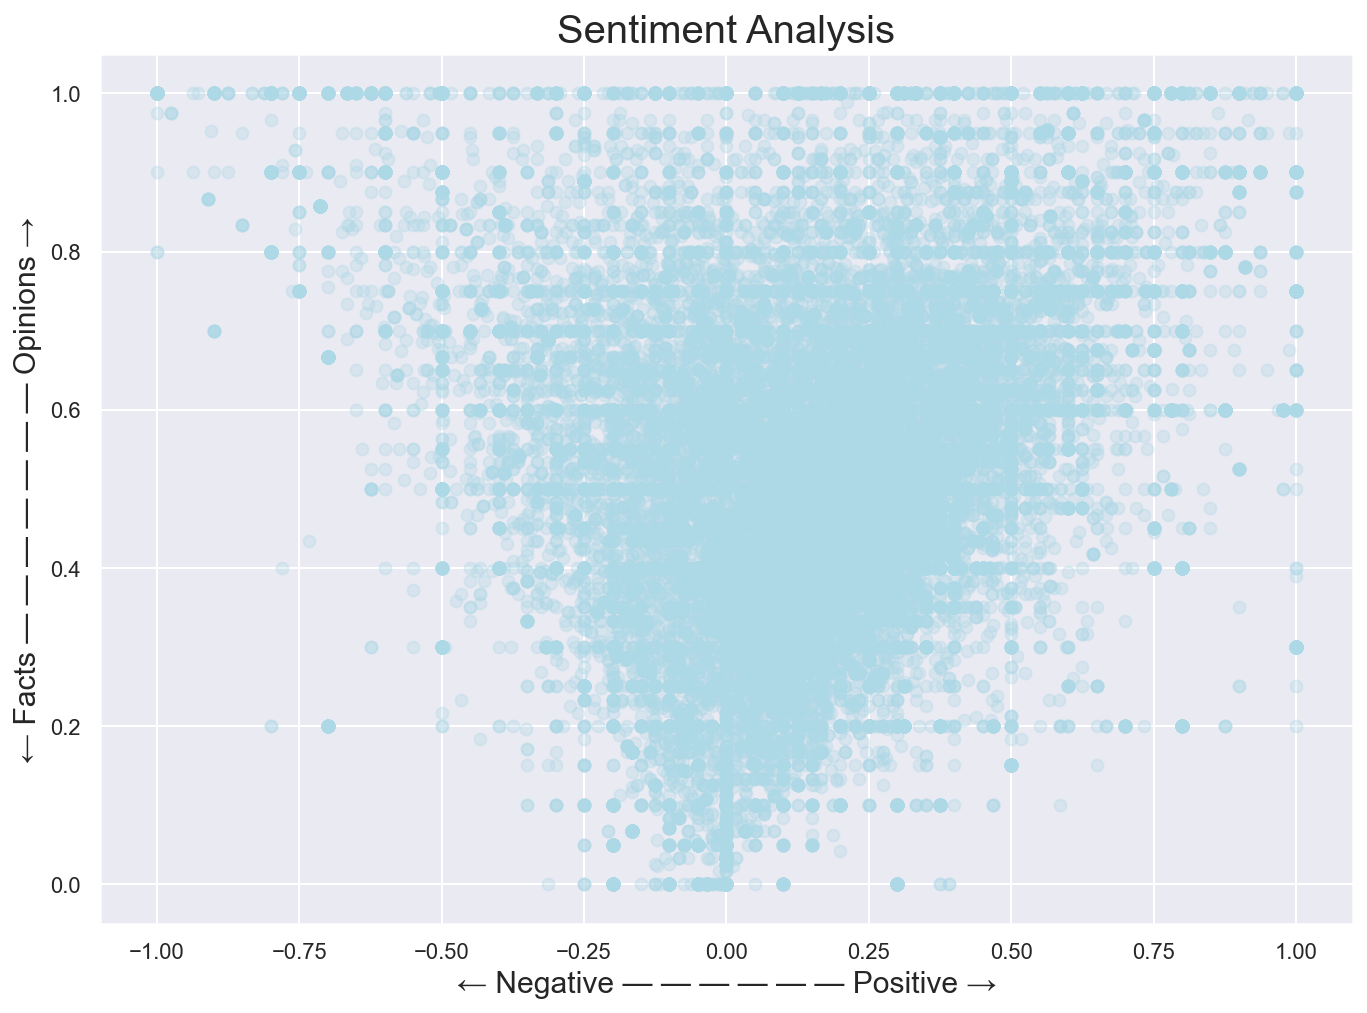

In [73]:
# Let’s plot the results
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
# for index, tweet_clean in enumerate(df_preproc.index):
x = df_preproc.polarity
y = df_preproc.subjectivity
plt.scatter(x, y, color='LightBlue', alpha=0.3) 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()

In [499]:

# Bin into positive, negative, and neutral sentiments
def get_sentiment(row):
        if row > 0.05:
            return 'Positive'
        elif row < -0.05:
            return 'Negative'
        else:
            return 'Neutral'
        
df_preproc['polarity_label'] = df_preproc['polarity'].apply(get_sentiment)


#### Valence Plot

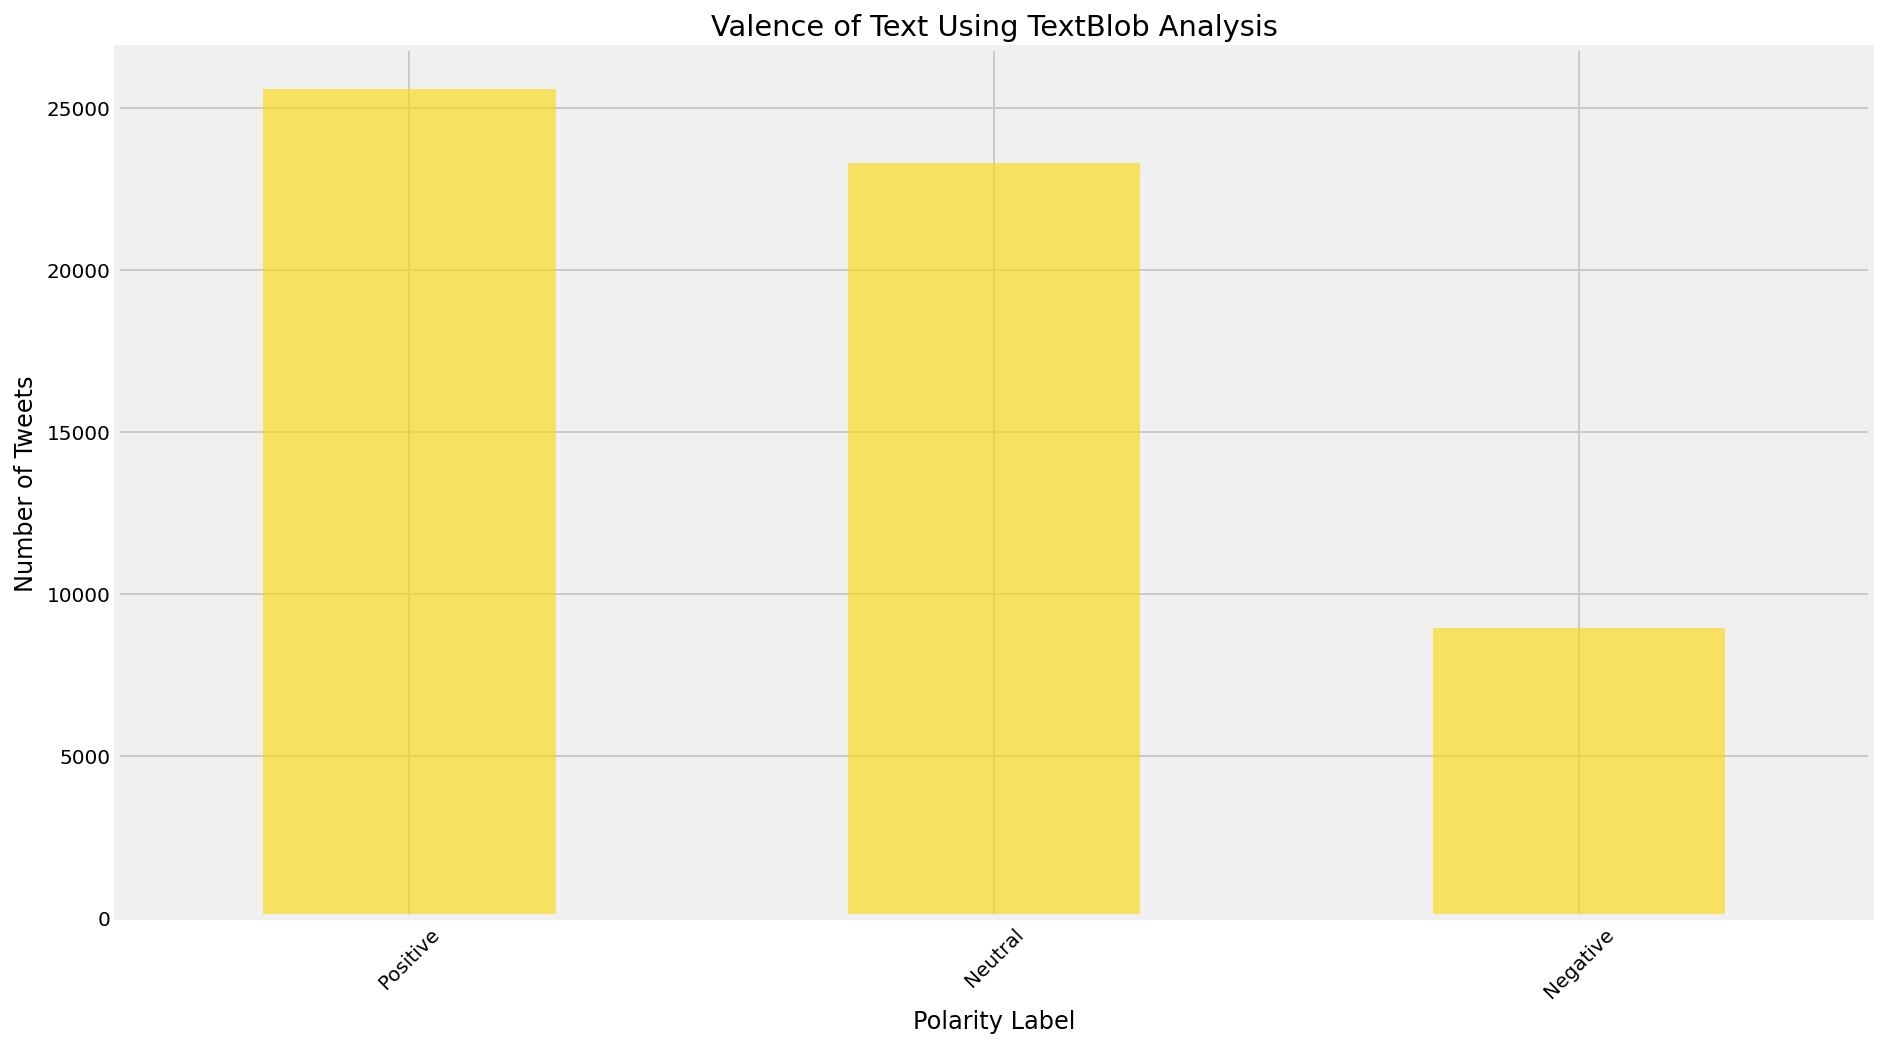

In [500]:
df_preproc.polarity_label.value_counts().plot(kind='bar', color='gold', alpha=0.6, figsize=(14, 8))
plt.xlabel('Polarity Label')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')
plt.title('Valence of Text Using TextBlob Analysis');

In [501]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

df_preproc['subjectivity'] = df_preproc['tweet_clean'].apply(subjectivity_calc)

In [502]:
# Bin subjectivity into 4 categories
def get_subjectivity(row):
        if row > 0.75:
            return 'Very biased'
        elif row > 0.5 and row < 0.75:
            return 'Biased'
        elif row < 0.25:
            return 'Very objective'
        else:
            return 'Objective'
    
df_preproc['subject_label'] = df_preproc['subjectivity'].apply(get_subjectivity)

#### Subjectivity Plot

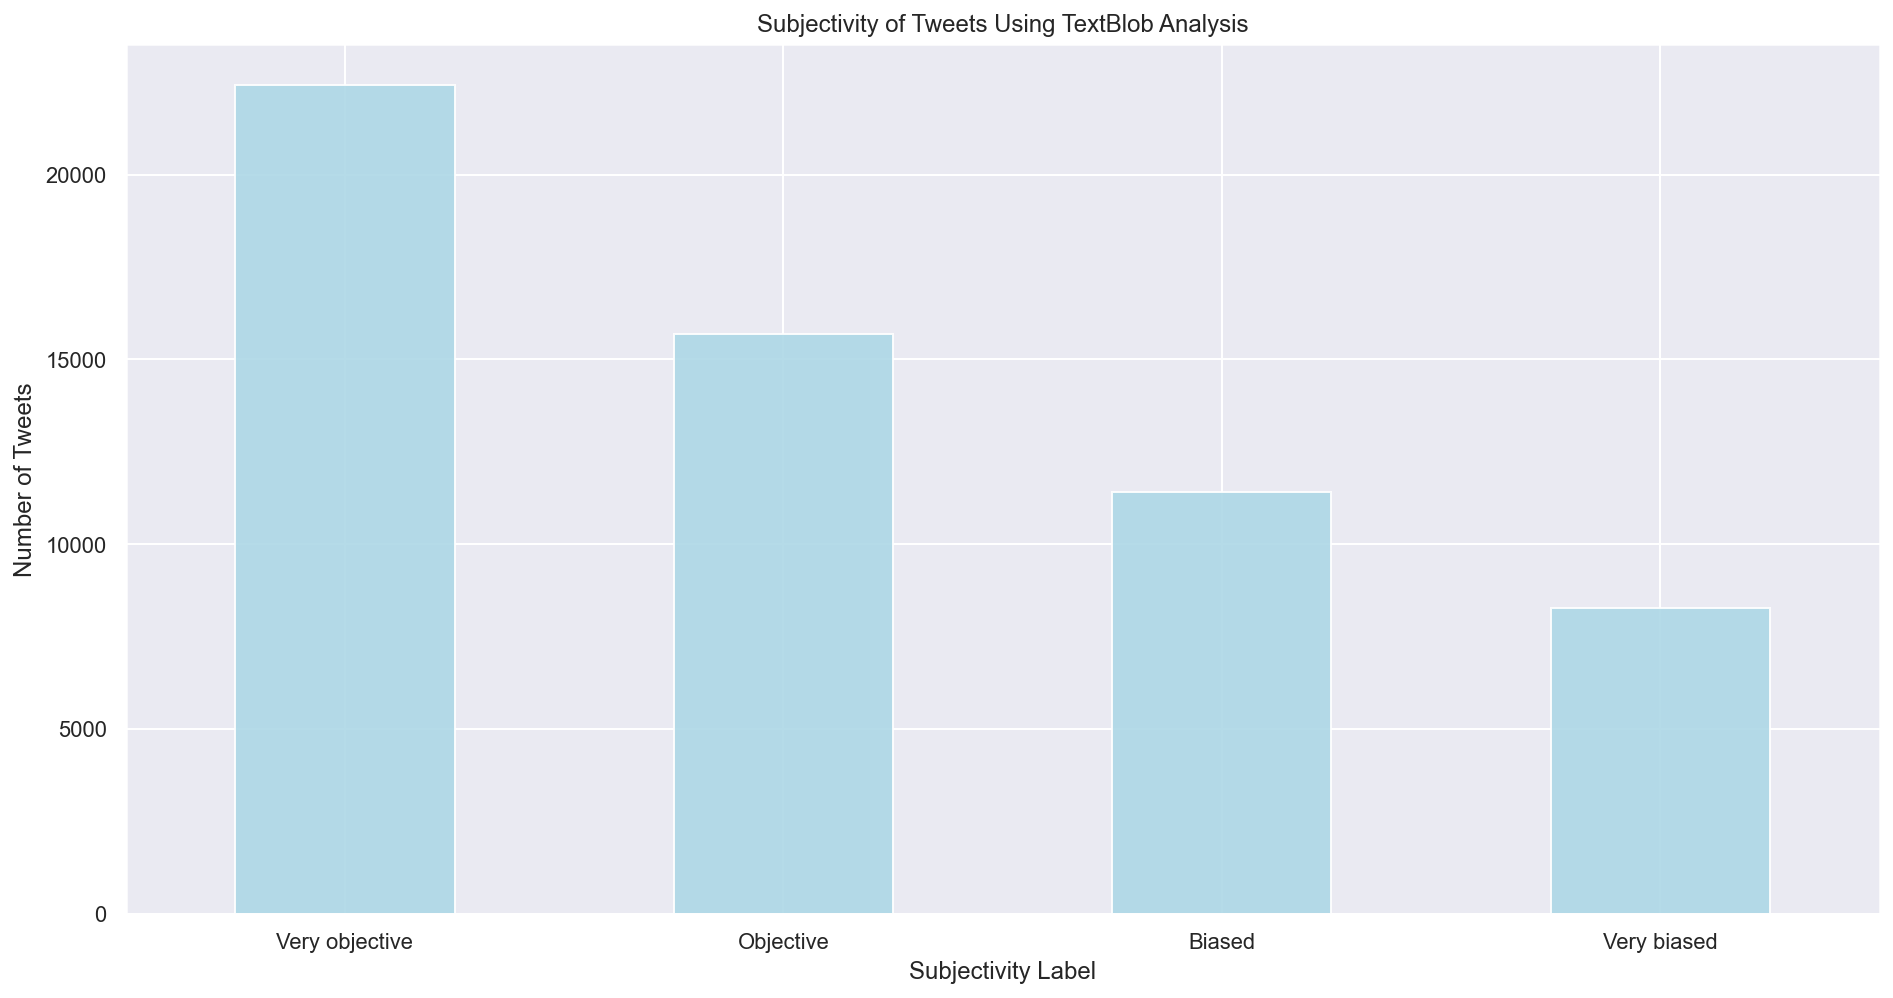

In [81]:
df_preproc.subject_label.value_counts().plot(kind='bar', color='lightblue', alpha=0.9, figsize=(14, 8))
plt.xlabel('Subjectivity Label')
plt.xticks(rotation=0)
plt.ylabel('Number of Tweets')
plt.title('Subjectivity of Tweets Using TextBlob Analysis');

### Generated Tweets

In [376]:
genny = pd.read_csv('Data/gpt2_gentext1_20210126.txt',  sep=None, header=None, 
                        error_bad_lines=False, warn_bad_lines=False)

In [382]:
genny.head(2)

,0
0,"Waddup, if you are so inclined, can I expect thee to procreate with me?"
1,Zapata's Fish Fry - the healthiest and tastiest fish recipe ever


In [383]:
genny.rename(columns={0: 'tweet_clean'}, inplace=True)
genny = genny[~genny['tweet_clean'].str.contains('\n====================\n')] 

In [380]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', "''", '""', '...', '``', 
                   'im', '\ufeff1', "'s", "n't", 'https', 'http', 'amp',
                   "'s", "n't", "like", "'m", "get", "'re", "day", "going", "good", 'something', 'look'
                   "new", "would", "today", 'today', 'would', 'one', '’', 'thank', 'back', 'go', 'make',
                   'want', 'right', 'know', 'see', 'way', 'really', 'let', 'first', 'say', 'rt', 'could',
                   'ca', "'ll", 'much', 'never', "'ve", 'take', 'every', 'got', 'man', 'year', 'yes', 'even',
                   'twitter', 'still', 'amp', 'thing', 'everyone', 'guy', 'im', 'talk', 'last', 'show', 
                   'look', 'made', 'need', 'also', 'two', 'book', 'https', 'http', 'well', 'come', 'little', 'watch',
                   'new', 'use', 'call', 'tweet', 'read', 'may', 'great', '\ufeff1', 'try', 'old', 'big', 'com',
                   'long', 'night', 'week', 'mean', 'keep', 'ask', 'name', 'lot', 'tonight', 'hard', 'always', 'sure',
                   'someone', 'ever', 'meet', 'stop', 'post', 'movie', 'eat', 'put', 'wait']

In [384]:
stopwords = set(stopwords_list)

In [386]:
genny = cleaner(genny, 'tweet_clean')
print(genny.info())
genny.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99573 entries, 0 to 103997
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  99573 non-null  object
 1   clean        99573 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None


,tweet_clean,clean
0,"Waddup, if you are so inclined, can I expect thee to procreate with me?",Waddup you are inclined can expect thee procreate with
1,Zapata's Fish Fry - the healthiest and tastiest fish recipe ever,Zapata Fish Fry the healthiest and tastiest fish recipe ever


In [387]:
%%time
genny['preproc_pipe'] = preprocess_pipe(genny['clean'])
genny[['tweet_clean', 'preproc_pipe']].head(2)

CPU times: user 1min 8s, sys: 1.38 s, total: 1min 9s
Wall time: 1min 10s


,tweet_clean,preproc_pipe
0,"Waddup, if you are so inclined, can I expect thee to procreate with me?","[waddup, incline, expect, thee, procreate]"
1,Zapata's Fish Fry - the healthiest and tastiest fish recipe ever,"[zapata, fish, fry, healthy, tastiest, fish, recipe]"


In [388]:
genny.preproc_pipe[0:2]

0    [waddup, incline, expect, thee, procreate]          
1    [zapata, fish, fry, healthy, tastiest, fish, recipe]
Name: preproc_pipe, dtype: object

In [389]:
genny.preproc_pipe[0][0]

'waddup'

In [390]:
total_vocab_gen = []

for tweet in genny.preproc_pipe:
    for word in tweet:
        total_vocab_gen.append(word)
print(len(total_vocab_gen))
print(len(set(total_vocab_gen)))

619743
54331


In [391]:
tweets_concat_gen = []
for tweet in genny.preproc_pipe:
    for word in tweet:
        tweets_concat_gen.append(word)
print(tweets_concat_gen[0:5])
len(tweets_concat_gen)

['waddup', 'incline', 'expect', 'thee', 'procreate']


619743

In [392]:
genny_nostops = [word for word in tweets_concat if word not in stopwords_list]

In [393]:
genny_dist = FreqDist(genny_nostops)
genny_dist.most_common(32)

[('love', 2490),
 ('think', 2398),
 ('time', 2349),
 ('people', 2119),
 ('work', 1730),
 ('realdonaldtrump', 1683),
 ('trump', 1648),
 ('world', 1128),
 ('give', 1060),
 ('live', 1038),
 ('life', 958),
 ('bite', 945),
 ('thanks', 926),
 ('tell', 918),
 ('feel', 906),
 ('find', 898),
 ('start', 851),
 ('help', 761),
 ('hope', 723),
 ('idea', 716),
 ('friend', 706),
 ('fun', 682),
 ('hear', 663),
 ('play', 663),
 ('human', 644),
 ('story', 624),
 ('change', 605),
 ('happy', 597),
 ('mind', 575),
 ('please', 571),
 ('president', 568),
 ('learn', 554)]

#### Most Frequent Words Plot

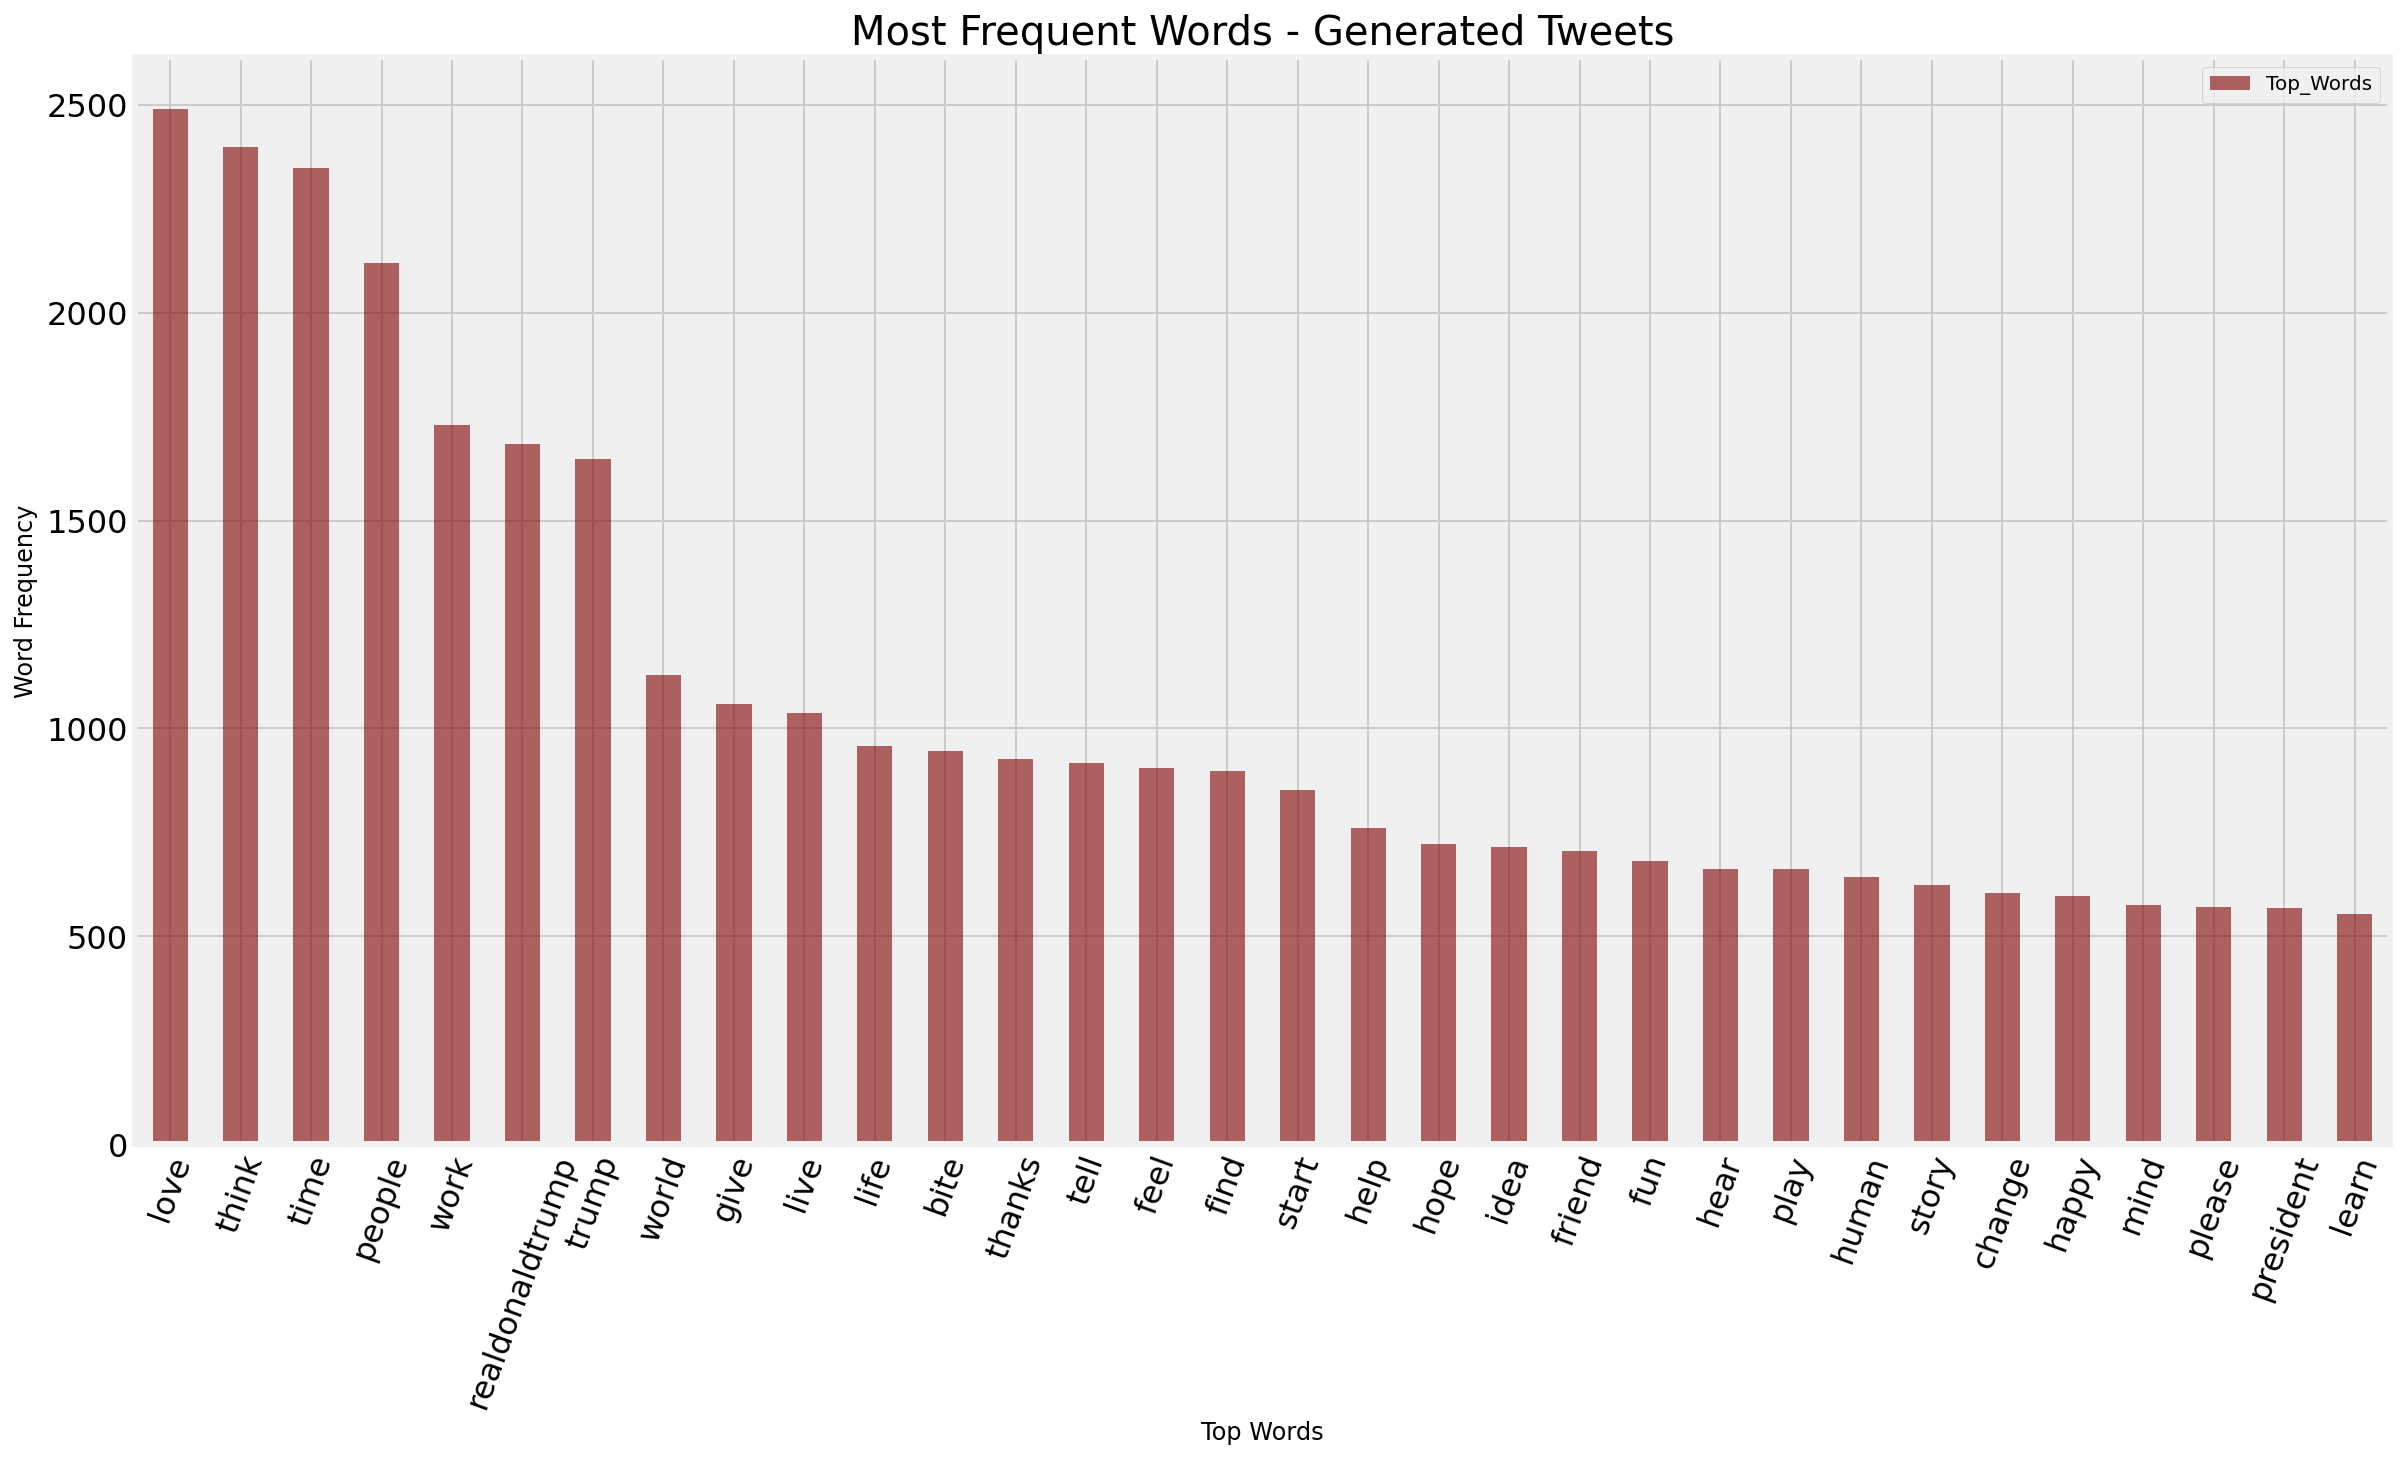

In [398]:
top_words = genny_dist.most_common(32)

gx_val = [x[0] for x in top_words]
gy_val = [x[1] for x in top_words]

gtwords = pd.DataFrame(gy_val, index=gx_val, columns =['Top_Words'])

gtwords.plot(kind='bar', alpha=0.6, color='maroon', figsize=(18,10), fontsize=16)
plt.xlabel('Top Words')
plt.ylabel('Word Frequency')
plt.title('Most Frequent Words - Generated Tweets', fontsize=20)
plt.xticks(rotation=70)
plt.show()

In [ ]:
labels = ['love', 'think', 'time', 'people', 'work', 'realdonaldtrump', 'trump', 
          'world', 'give', 'live','life', 'bite', 'thanks']
fake_sub = [28, 291, 789, 184]
real_sub = [20, 139, 504, 91]
width = 0.50       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(labels, fake_sub, width, label='Fake', color='lightblue')
ax.bar(labels, real_sub, width, bottom=fake_sub, label='Real', color='gold', alpha=0.6)

ax.set_ylabel('Article Count')
ax.set_title('Subjectivity of Fake vs. Real News')
ax.legend()

plt.show()

In [401]:
polarity = (lambda x: TextBlob(x).sentiment.polarity)
subjectivity = (lambda x: TextBlob(x).sentiment.subjectivity)
genny['polarity'] = genny['tweet_clean'].apply(polarity)
genny['subjectivity'] = genny['tweet_clean'].apply(subjectivity)

In [404]:
genny[['polarity', 'subjectivity']][0:5]

,polarity,subjectivity
0,0.000000,0.000000
1,0.000000,0.000000
2,0.125000,0.750000
3,0.516667,0.183333
4,0.200000,0.200000


In [423]:
gtwords.head(2)

,Top_Words
love,2490
think,2398


In [429]:
twords.head(2)

,Top_Words
think,233
love,182


In [ ]:
columns={0: 'tweet_clean'}

In [435]:
twords.rename(columns={'Top_Words': 'Real_Words'}, inplace=True)

In [457]:
meow = gtwords.merge(twords, left_index=True, right_index=True)

In [458]:
meow.head(2)

,Top_Words,Real_Words
love,2490,182
think,2398,233


In [461]:
normalized_df=(meow-meow.min())/(meow.max()-meow.min())

In [464]:
normalized_df.rename(columns={'Top_Words': 'Gen_Words'}, inplace=True)

##### Normalized Word Frequency - Combined Tweets

In [1]:
import plotly.express as px
  
fig = px.bar(normalized_df[0:9], barmode = 'stack', title='Normalized Word Frequency - Real vs. Generated Tweets',
            color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.update_xaxes(title="Words")
fig.update_yaxes(title="Normalized Frequency")
fig.show()

NameError: name 'normalized_df' is not defined

#### Valence Plot

In [409]:
# Bin into positive, negative, and neutral sentiments
def get_sentiment(row):
        if row > 0.05:
            return 'Positive'
        elif row < -0.05:
            return 'Negative'
        else:
            return 'Neutral'
        
genny['polarity_label'] = genny['polarity'].apply(get_sentiment)


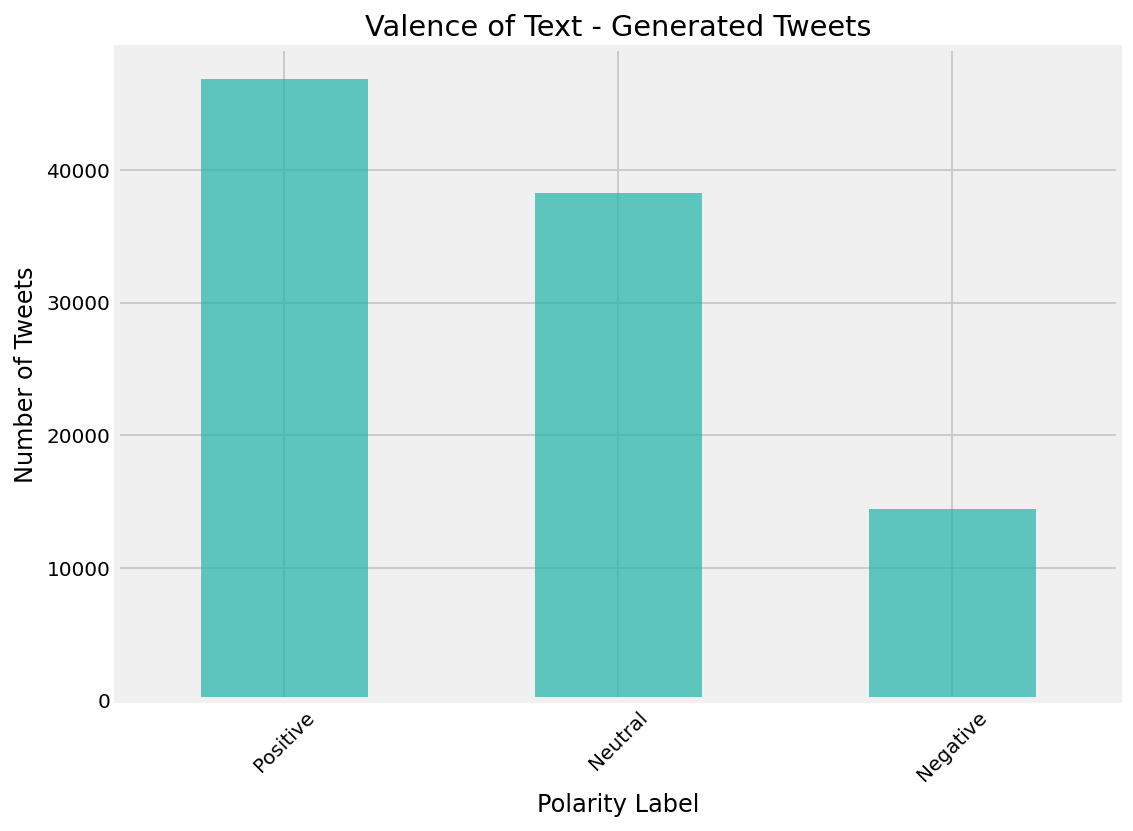

In [421]:
genny.polarity_label.value_counts().plot(kind='bar', color='lightseagreen', alpha=0.7, figsize=(8, 6))
plt.xlabel('Polarity Label')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')
plt.title('Valence of Text - Generated Tweets');

In [489]:
gn = pd.DataFrame(genny.polarity_label.value_counts())

In [491]:
gn.rename(columns={'polarity_label': 'Gen_Tweets'}, inplace=True)

In [503]:
rn = pd.DataFrame(df_preproc.polarity_label.value_counts())
rn.rename(columns={'polarity_label': 'Real_Tweets'}, inplace=True)

In [509]:
meowth = gn.merge(rn, left_index=True, right_index=True)
meowth.head(3)

,Gen_Tweets,Real_Tweets
Positive,46856,25587
Neutral,38253,23292
Negative,14464,8934


In [ ]:
normalized_df=(df-df.mean())/df.std()


In [513]:
meowth_norm=(meowth-meowth.min())/(meowth.max()-meowth.min())
meowth_norm.head(2)

,Gen_Tweets,Real_Tweets
Positive,1.00000,1.000000
Neutral,0.73441,0.862187


##### Normalized Sentiment - Combined Tweets

In [536]:
fig = px.bar(meowth_norm, barmode = 'stack', title='Normalized Sentiment - Real vs. Generated Tweets',
            color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_xaxes(title="Sentiment")
fig.update_yaxes(title="Normalized Count")
fig.show()

Negatives made up a small amount and were sent to 0 with min-max scaler.

#### Subjectivity Plot

In [415]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

genny['subjectivity'] = genny['tweet_clean'].apply(subjectivity_calc)

In [416]:
# Bin subjectivity into 4 categories
def get_subjectivity(row):
        if row > 0.75:
            return 'Very biased'
        elif row > 0.5 and row < 0.75:
            return 'Biased'
        elif row < 0.25:
            return 'Very objective'
        else:
            return 'Objective'
    
genny['subject_label'] = genny['subjectivity'].apply(get_subjectivity)

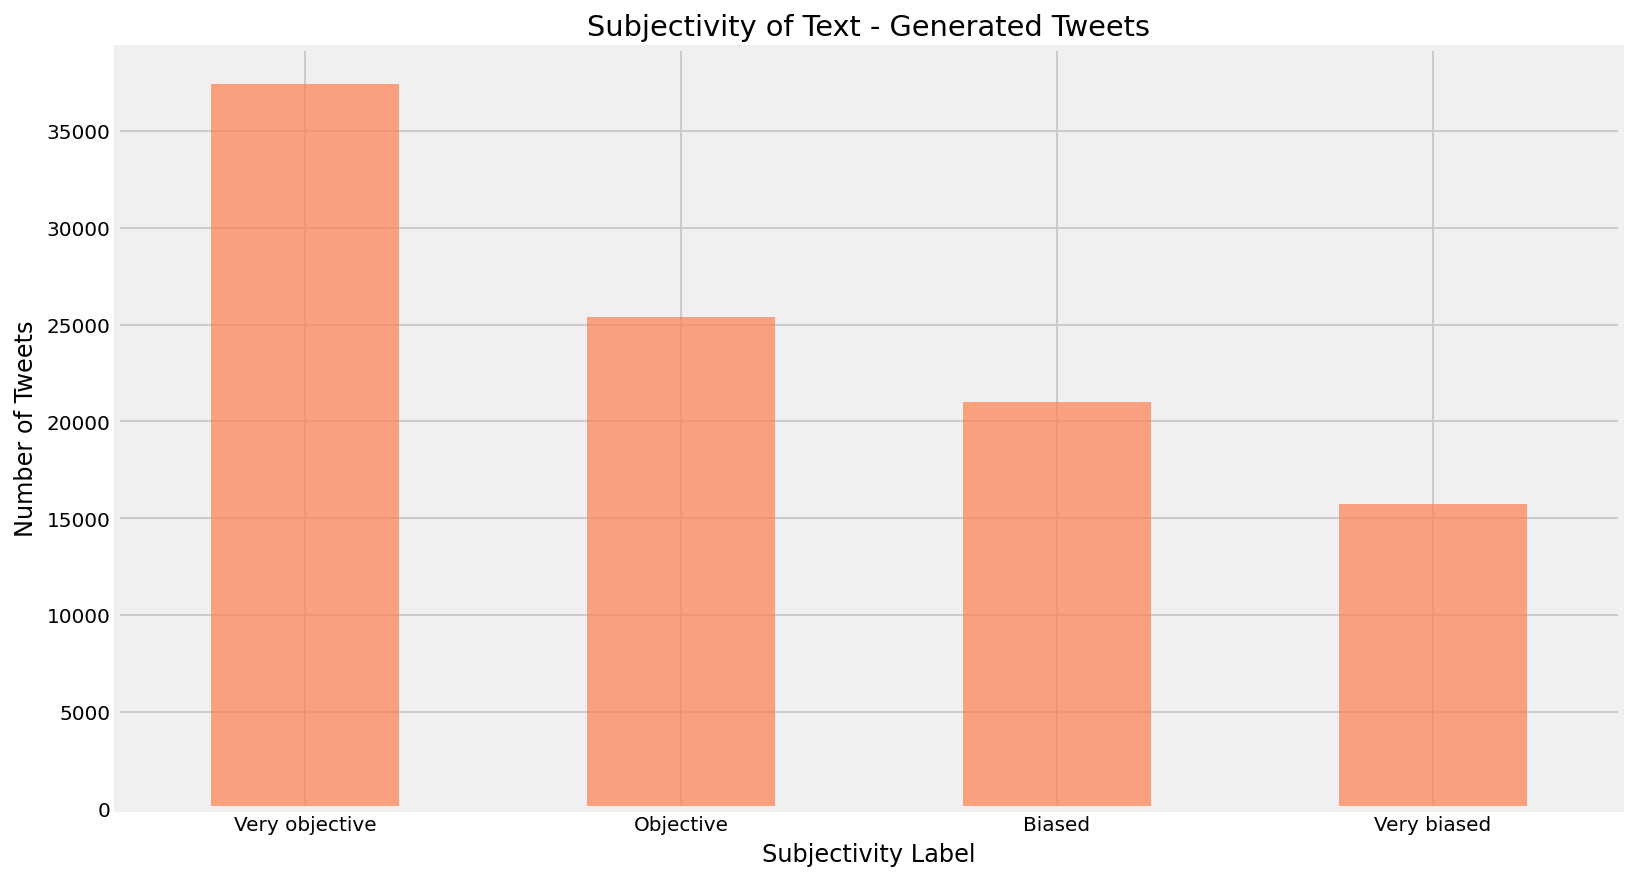

In [422]:
genny.subject_label.value_counts().plot(kind='bar', color='coral', alpha=0.7, figsize=(12, 7))
plt.xlabel('Subjectivity Label')
plt.xticks(rotation=0)
plt.ylabel('Number of Tweets')
plt.title('Subjectivity of Text - Generated Tweets');

In [528]:
gy = pd.DataFrame(genny.subject_label.value_counts())

In [529]:
gy.rename(columns={'subject_label': 'Gen_Tweets'}, inplace=True)

In [530]:
ry = pd.DataFrame(df_preproc.subject_label.value_counts())
ry.rename(columns={'subject_label': 'Real_Tweets'}, inplace=True)

In [531]:
meowzers = gy.merge(ry, left_index=True, right_index=True)
meowzers.head(3)

,Gen_Tweets,Real_Tweets
Very objective,37434,22427
Objective,25407,15685
Biased,20993,11417


In [534]:
meowzers_norm=(meowzers-meowzers.min())/(meowzers.max()-meowzers.min())
meowzers_norm.head(4)

,Gen_Tweets,Real_Tweets
Very objective,1.000000,1.000000
Objective,0.445633,0.523298
Biased,0.242176,0.221523
Very biased,0.000000,0.000000


##### Normalized Objectivity - Combined Tweets

In [535]:
fig = px.bar(meowzers_norm, barmode = 'stack', title='Normalized Objectivity - Real vs. Generated Tweets',
            color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_xaxes(title="Objectivity")
fig.update_yaxes(title="Normalized Count")
fig.show()

# Modeling - Validating Generated Tweets

### Combining DataFrames

In [4]:
import sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
gen_text = pd.read_csv('Data/gpt2_gentext1_20210126.txt',  sep=None, header=None, 
                        error_bad_lines=False, warn_bad_lines=False)

In [7]:
gen_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103998 entries, 0 to 103997
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       103998 non-null  object
dtypes: object(1)
memory usage: 812.6+ KB


In [8]:
# See full tweets
pd.set_option('display.max_colwidth', -1)

In [9]:
# Tweets generated by my baby language model
gen_text.head()

,0
0,"Waddup, if you are so inclined, can I expect thee to procreate with me?"
1,Zapata's Fish Fry - the healthiest and tastiest fish recipe ever
2,@webMD Is that possible? That sounds like something I'd be interested in learning about.
3,@timdonakowski maybe not the best metaphor for social media time.
4,How much does your pet goat price increase every year?


In [10]:
gen_text[5:20]

,0
5,"@sniggo On the bright side, expect the Zika virus."
6,@webMD Getting better at math wordplay.
7,"@magicmoney Fake news, shiny things, saving money on your car insurance. Hey you're for it."
8,@magicmoney I saved up for you guys. The video is worth it anyway.
9,@magicmoney Did you see my comment on CNBC's Prudential?
10,"@tranism I can dance, say I'm a genius, get hired, wear a cape, drink Pinot Noir, fly. In space."
11,"Today, let's all remember and celebrate those who say ""sounds bad"" every day."
12,@JenniferJJacobs Your father was Henry Clay Clay Shaw.
13,"Having a fun day. Daring to dream, in other words."
14,@realDonaldTrump Remember when $700 billion in taxpayer money was used to pay\n====================\nSay Hello to Trump Generals


Row 14 shows a problem. It combines the last tweet generated in a batch (often truncated because of length constrains), the "========" batch separator, and the short/random topic sentence that begins a batch.

We'll try to remove that.

P.S. I didn't notice that at first before class-vali-cation (get it, classification validation together...). This may be one of the things the model keyed in on.

In [11]:
gen_text.isnull().sum()

0    0
dtype: int64

In [12]:
# Fixing dat column name
gen_text.rename(columns={0: 'tweet_clean'}, inplace=True)

In [13]:
gen_text2[5:20]

,0
5,"""@sniggo On the bright side, expect the Zika virus."""
6,"""@webMD Getting better at math wordplay."""
7,"""@magicmoney Fake news, shiny things, saving money on your car insurance. Hey you're for it."""
8,"""@magicmoney I saved up for you guys. The video is worth it anyway."""
9,"""@magicmoney Did you see my comment on CNBC's Prudential?"""
10,"""@tranism I can dance, say I'm a genius, get hired, wear a cape, drink Pinot Noir, fly. In space."""
11,"""Today, let's all remember and celebrate those who say """"sounds bad"""" every day."""
12,"""@JenniferJJacobs Your father was Henry Clay Clay Shaw."""
13,"""Having a fun day. Daring to dream, in other words."""
14,"""@realDonaldTrump Remember when $700 billion in taxpayer money was used to pay"


In [14]:
# Return all rows not containing that \n===\n string
gen_text = gen_text[~gen_text['tweet_clean'].str.contains('\n====================\n')] 

In [15]:
gen_text[12:15]

,tweet_clean
12,@JenniferJJacobs Your father was Henry Clay Clay Shaw.
13,"Having a fun day. Daring to dream, in other words."
15,"@realDonaldTrump As a child, did you have a beloved sled?"


Hot diggity dog, it worked!

In [16]:
gen_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99573 entries, 0 to 103997
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  99573 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [17]:
gen_text['label'] = 0
gen_text.head()

,tweet_clean,label
0,"Waddup, if you are so inclined, can I expect thee to procreate with me?",0
1,Zapata's Fish Fry - the healthiest and tastiest fish recipe ever,0
2,@webMD Is that possible? That sounds like something I'd be interested in learning about.,0
3,@timdonakowski maybe not the best metaphor for social media time.,0
4,How much does your pet goat price increase every year?,0


Reading in real text data scraped from the ether...

In [18]:
real_text = pd.read_csv('Data/all_tweets_cleaned.csv')

In [19]:
real_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57813 entries, 0 to 57812
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  57813 non-null  object
dtypes: object(1)
memory usage: 451.8+ KB


In [20]:
real_text.head()

,tweet_clean
0,"After Covid, people with soul patches should still have to wear a mask."
1,Ill never get used to having a First Lady who is not from Slovenia
2,"6.8 miles below the sea is the Marianas Trench, and 6.8 miles below that is the bar Trump set for Biden."
3,Im looking forward to sweating the small stuff again.
4,Easy compromise: Lower the maximum wage to $15/hour.


In [21]:
real_text['label'] = 1

In [22]:
real_text.head()

,tweet_clean,label
0,"After Covid, people with soul patches should still have to wear a mask.",1
1,Ill never get used to having a First Lady who is not from Slovenia,1
2,"6.8 miles below the sea is the Marianas Trench, and 6.8 miles below that is the bar Trump set for Biden.",1
3,Im looking forward to sweating the small stuff again.,1
4,Easy compromise: Lower the maximum wage to $15/hour.,1


0 and 1 represents generated and real tweets, respectively.

Randomly sampled 15,000 tweets from AI-generated and real tweet datasets in preparation for classification.

In [23]:
sub_gen = gen_text.sample(n=15000, random_state=42)
sub_gen.head()

,tweet_clean,label
61534,@ESPNStatsInfo I would think at least a six-win season with streaks of wins every other year.,0
64688,@bevanhouston Right next to the Hall of Wives.,0
41462,@InsideOutMom @InsideOutMom Hands down the best episode so far. #Onepieceiscoming #ProphecyDay,0
15141,"I just watched The Lorax, twice. The third time I was watching a rerun of it at my desk. In the 80s. Once thought sane, twice. Funny, dude.",0
50705,@realDonaldTrump This is what you do now.,0


In [24]:
sub_real = real_text.sample(n=15000, random_state=42)
sub_real.head()

,tweet_clean,label
34856,Me getting mad at the sidewalk when I trip.,1
31392,Choose Your Favorite Gravitational Wave And We'll Tell You Which BTS Member Is Your Soulmate,1
50752,@realDonaldTrump You are so negative. Do the Locomotion with me Mr. Trump.,1
45674,It's very satisfying and all I want to do is watch it over and over again.,1
20966,"According to the top critics on Rotten Tomatoes, Oliver Stone's job performance isn't that much higher than Bush's.",1


In [25]:
tweets_together = sub_real.append(sub_gen)
tweets_together.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 34856 to 102694
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  30000 non-null  object
 1   label        30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


In [26]:
tweets_together.head()

,tweet_clean,label
34856,Me getting mad at the sidewalk when I trip.,1
31392,Choose Your Favorite Gravitational Wave And We'll Tell You Which BTS Member Is Your Soulmate,1
50752,@realDonaldTrump You are so negative. Do the Locomotion with me Mr. Trump.,1
45674,It's very satisfying and all I want to do is watch it over and over again.,1
20966,"According to the top critics on Rotten Tomatoes, Oliver Stone's job performance isn't that much higher than Bush's.",1


In [27]:
# Not sure if shuffling matters or not... but it doesn't seem right to leave them perfectly separated
from sklearn.utils import shuffle
tweets_together = shuffle(tweets_together)
tweets_together.head()

,tweet_clean,label
34746,"@darth It should make him sad like when I see an ""Athletic Fit"" shirt I like.",1
16694,"I don't say it enough. Thanks for not murdering me, everyone.",1
18192,@AndreaScher Send a medic. Someone to take away his shields.,0
22835,@JoshNBCNews Only Hyde Dog in Hell could out-Dance and out-Morgue Ruta.,0
43294,Long sleepless night in store for Paul Ryan going over and over again in his mind what slide he should have included in his Powerpoint deck.,1


In [28]:
tweets_together.to_csv('modeling_tweets.csv', index=False)

### TTS + TFIDF Time

In [29]:
X = tweets_together['tweet_clean']
y = tweets_together['label']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print(y_test.shape)
X_train.shape

(6000,)


(24000,)

In [31]:
# Resetting stop words after adding on for freq dist
from nltk.corpus import stopwords
import string
stopwords.words('english')

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']
stopwords_list[12:16]

["you'd", 'your', 'yours', 'yourself']

In [32]:
tfidorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,3), max_features=200000)

X_train = tfidorizer.fit_transform(X_train)
X_test = tfidorizer.transform(X_test)

# Certain models require dense arrays - TFIDF saves as sparse
# Primarily Naive Bayes
X_train_dense = X_train.todense()
X_test_dense = X_test.todense()

print(tfidorizer.get_feature_names()[200:220])


['2004', '2005', '2008', '2009', '2010', '2011', '2011 first', '2012', '2013', '2014', '2014 2015', '2015', '2015 favorite', '2016', '2016 election', '2016 year', '2017', '2018', '2018 going', '2018 photo']


### Classifier for Validation

Using classifiers models as an ad-hoc validation for my GPT-2 language model. The idea here is to run a binary clasification of a dataset comprised of real tweets (that were scraped) and generated tweets. 

If the language model is doing a good job at generating realistic tweets, the classifier will have trouble predicting which is real or generated. An accuracy score near 50% means the classifier is performing on par with random guessing - signifying well generated tweets!

#### Naive Bayes

In [162]:
# Instantiating Naive Bayes classifier
nb_classifier = GaussianNB()

t0 = time.time()

# Fit NB classifier
nb_classifier.fit(X_train_dense, y_train)
t1 = time.time()
total = t1-t0
print(total,'s\n')

# Fortune telling...
nb_train_preds = nb_classifier.predict(X_train_dense)
nb_test_preds = nb_classifier.predict(X_test_dense)

1085.685024023056 s

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11953
           1       1.00      0.98      0.99     12047

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



In [251]:
print('Train', classification_report(y_train, nb_train_preds))
print('Test', classification_report(y_test, nb_test_preds))

Train               precision    recall  f1-score   support

           0       0.98      1.00      0.99     11953
           1       1.00      0.98      0.99     12047

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

Test               precision    recall  f1-score   support

           0       0.56      0.73      0.64      3047
           1       0.60      0.41      0.49      2953

    accuracy                           0.57      6000
   macro avg       0.58      0.57      0.56      6000
weighted avg       0.58      0.57      0.56      6000



The classifier performed almost perfectly on the train set but quite worse on the test set. I'm guessing the model keyed in on very specific differences between the real and generated tweets.

The slightly better than random-guessing, at 57% overall, is a good sign for the validity of our generated tweets. An interesting follow-up would be to have humans label and see how well they do. 

#### Random Forest

In [35]:
# Onto the ensembles... instantiate random forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
# Fit Random Forest
rf_classifier.fit(X_train, y_train)
t1 = time.time()

total = t1-t0
print(total,'s')


# Prediction time
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

276.661741733551 s


In [36]:
print('Train', classification_report(y_train, rf_train_preds))
print('Test', classification_report(y_test, rf_test_preds))

Train               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12012
           1       1.00      1.00      1.00     11988

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

Test               precision    recall  f1-score   support

           0       0.57      0.77      0.66      2988
           1       0.65      0.44      0.52      3012

    accuracy                           0.60      6000
   macro avg       0.61      0.60      0.59      6000
weighted avg       0.61      0.60      0.59      6000



Random Forest performed better at predicting the differences between the two tweet-types. Still, 62% isn't bad. We can look at what features were most important for classifying.

##### Commenting out gridsearch so I don't accidentally run it and lose the read-out.

In [115]:
# from sklearn.model_selection import GridSearchCV
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 2, 6, 10],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [3, 6]
# }

# t0 = time.time()

# gs_rf = GridSearchCV(rf_classifier, rf_params, cv=2)

# gs_rf.fit(X_train, y_train)

# print(f"Training Accuracy: {gs_rf.best_score_ :.2%}")
# print("")
# print(f"Optimal Parameters: {gs_rf.best_params_}")

# t1 = time.time()
# total = t1-t0
# print('\n',total,'s\n')

# rf_score = (gs_rf.score(X_test, y_test)*100)

# print('Random forest grid search: {}%'.format((round(rf_score, 2))))

Training Accuracy: 62.35%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300}

 4818.847690820694 s

Random forest grid search: 62.52%


Interesting that our grid search shows a reduction in accuracy on the training set.

#### Post-Modeling Feature Importance EDA

In [189]:
from scipy import sparse
from scipy.sparse import csc_matrix


In [375]:
feature_names=tfidorizer.get_feature_names()
feature_names[990]

'alt'

In [174]:
# Functions to determine the words with the highest TF-IDF score (measure of importance)

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [184]:
# Sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(X_train.tocoo())

# Extract only the top n; n here is 20
keywords=extract_topn_from_vector(feature_names,sorted_items,20)

# now print the results
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
works 1.0
wig 1.0
welcome 1.0
watching 1.0
watched 1.0
vaspers 1.0
uuue 1.0
traffic 1.0
tough 1.0
touch 1.0
together 1.0
thehill 1.0
thanks 1.0
thank 1.0
teamobamagirl 1.0
teaching 1.0
steverubel 1.0
spokane 1.0
sosorryitwasnibblyteens 1.0


Above are the words with the highest TFIDF scores.

##### Important Features - Random Forest

In [38]:
# Create a dataframe with the feature importance scores from RF classifier paired with the feature names (words)
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = tfidorizer.get_feature_names(),
                                   columns=['importance']).sort_values('importance', ascending=False)

In [39]:
feature_importances.head()

,importance
emptywheel,0.002358
barbinnebraska,0.002345
great,0.002210
thank,0.002141
good,0.002094


I guess barbinnebraska is a dead giveaway.

Must be something weird about people from Nebraska... 

In [ ]:
twords.plot(kind='bar', alpha=0.7, color='seagreen', figsize=(18,10), fontsize=16)
plt.xlabel('Top Words')
plt.ylabel('Word Frequency')
plt.title('Most Frequent Words - Full DF', fontsize=20)
plt.xticks(rotation=70)
plt.show()

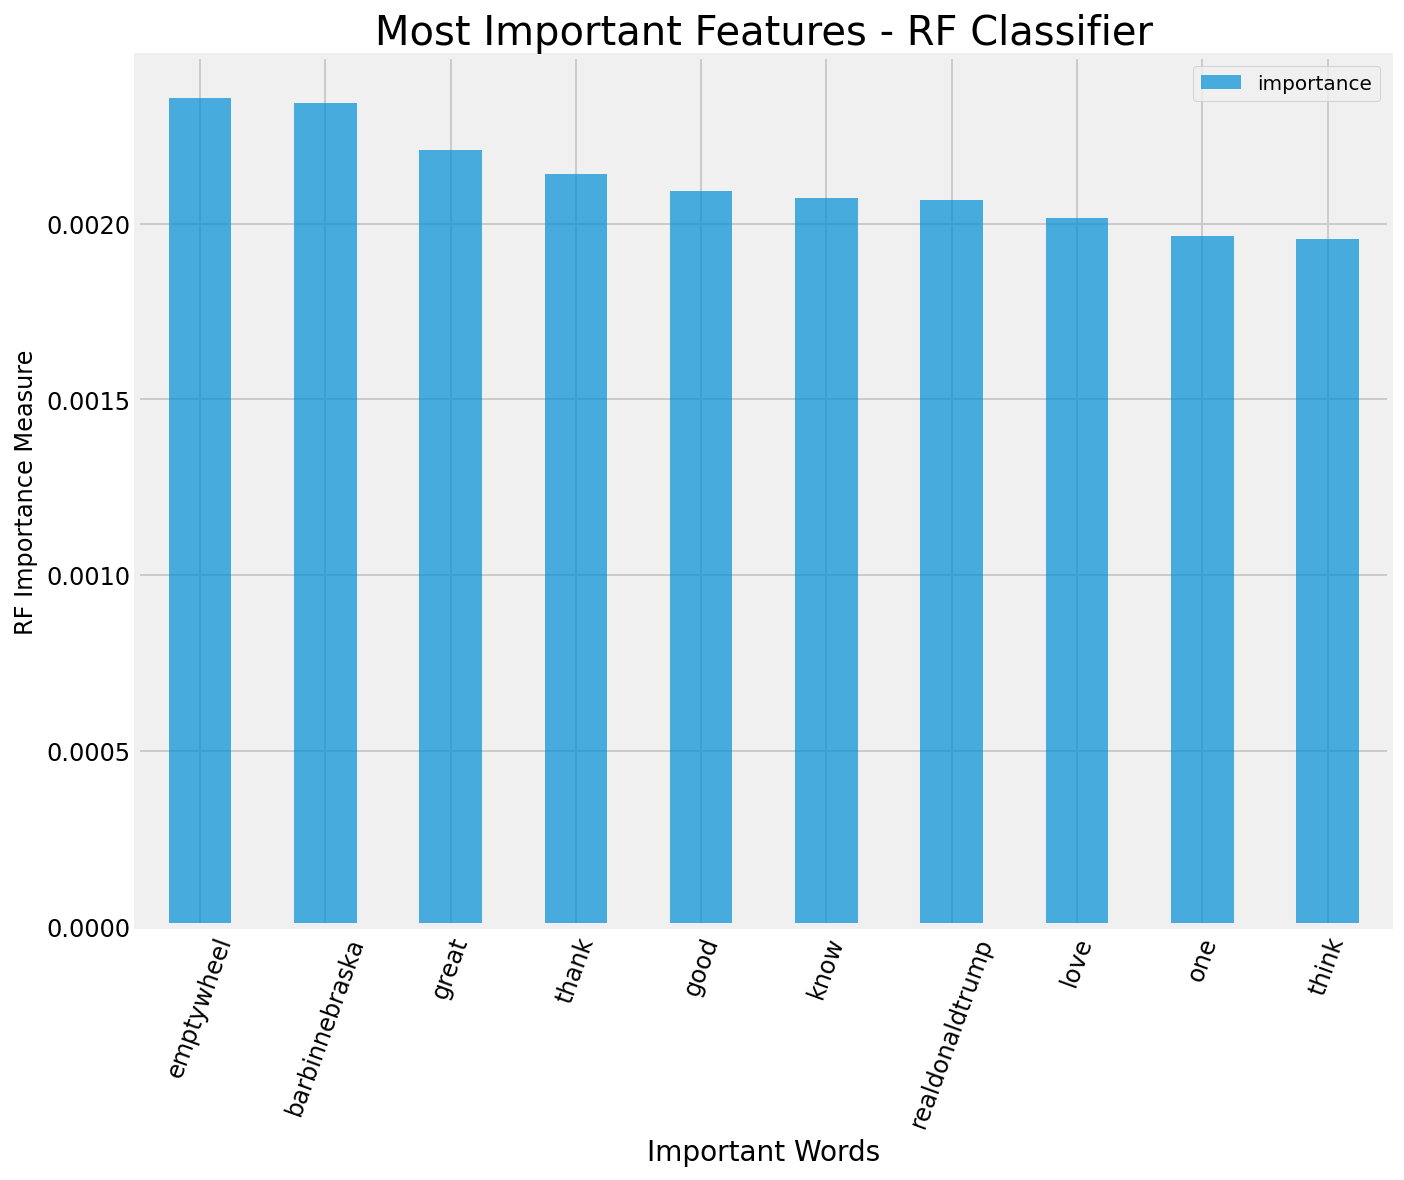

In [163]:
feature_importances[0:10].plot(kind='bar', alpha=0.7, figsize=(10,8), fontsize=12)
plt.xlabel('Important Words', fontsize=14)
plt.ylabel('RF Importance Measure')
plt.title('Most Important Features - RF Classifier', fontsize=20)
plt.xticks(rotation=70)
plt.show();

In [41]:
# Since they're both arrays, we can perform this simple subtraction
# A 0 means they were classified correctly (i.e. 1-1 = 0, 0-0=0)
# A -1 or 1 means they were misclassified
i = rf_test_preds - y_test

In [42]:
predicted = pd.Series(i)

In [43]:
predicted = predicted.to_frame()

In [44]:
# That's better...
# So 0 means it was classified correctly and -1 is misclassified
# For our purposes, it may be more interesting to see which ones were classified correctly
predicted.head()

,label
25111,-1
56278,-1
72892,0
35799,0
28374,0


In [45]:
predicted.value_counts()

label
 0       3610
-1       1695
 1       695 
dtype: int64

In [46]:
# return only correctly labeled
# use it to locate the rows from the original dataframe to see label and tweet

In [90]:
correct = predicted.loc[predicted.label == 0]
correct.value_counts()

label
0        3610
dtype: int64

In [88]:
incorrect = predicted.query('label==-1 or label==1')
incorrect.value_counts()

label
-1       1695
 1       695 
dtype: int64

In [91]:
iindx = incorrect.index
iindx = list(iindx)

In [92]:
incorrected = tweets_together.loc[tweets_together.index.isin(iindx) == True]

In [93]:
incorrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 11388 to 39203
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  2728 non-null   object
 1   label        2728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.9+ KB


In [95]:
incorrected.drop_duplicates(inplace=True)
incorrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 11388 to 39203
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  2725 non-null   object
 1   label        2725 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.9+ KB


In [96]:
cindx = correct.index
cindx = list(cindx)

In [97]:
corrected = tweets_together.loc[tweets_together.index.isin(cindx) == True]

In [98]:
corrected.head()

,tweet_clean,label
10869,@Kroosh: You don't have to be a dick about it.,0
381,"@stephenfhayes Who you playing Patsy? I play, I own the damn thing. What are you playing? Whatever it is.",0
14658,"It would be so cool if Panama used Van Halen for their national anthem and even cooler if they used ""Hot for Teacher"" instead of ""Panama.""",1
13338,@AnnieR: Not if you're trying to be funny. And not funny until you realize what she's trying to say.,0
30291,"Live webcasts: HHDL will teach on A Guide to the Bodhisattvas Way of Life from Dharamsala, India, on Aug 30 - Sep 1",1


In [99]:
corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4099 entries, 10869 to 27301
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  4099 non-null   object
 1   label        4099 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.1+ KB


In [100]:
corrected.drop_duplicates(inplace=True)
corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 10869 to 27301
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  4067 non-null   object
 1   label        4067 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.3+ KB


In [ ]:
# Why would it be 567 more? 
# Different method reduced it but still greater... we'll carry on for now

In [101]:
corrected.isnull().sum()

tweet_clean    0
label          0
dtype: int64

In [102]:
incorrected['length'] = incorrected.tweet_clean.apply(len)

In [103]:
corrected['length'] = corrected.tweet_clean.apply(len)
corrected.length.value_counts()

51     53
71     52
56     51
61     51
86     49
       ..
19     1 
21     1 
161    1 
189    1 
304    1 
Name: length, Length: 235, dtype: int64

In [108]:
# Total tweet data
tweets.length.describe()

count    57813.000000
mean     89.238441   
std      42.541906   
min      31.000000   
25%      57.000000   
50%      85.000000   
75%      113.000000  
max      465.000000  
Name: length, dtype: float64

In [109]:
# Correctly classified tweets
corrected.length.describe()

count    4067.000000
mean     88.254487  
std      42.260824  
min      19.000000  
25%      57.000000  
50%      82.000000  
75%      112.000000 
max      304.000000 
Name: length, dtype: float64

In [110]:
incorrected.length.describe()

count    2725.000000
mean     86.239633  
std      41.986391  
min      17.000000  
25%      54.000000  
50%      80.000000  
75%      111.000000 
max      344.000000 
Name: length, dtype: float64

In [ ]:
# It's unlikely that one or two character was the difference maker

In [129]:
%run -i "frequency_dist.py"


<Figure size 432x288 with 0 Axes>

In [117]:
cleaner(corrected, 'tweet_clean')

,tweet_clean,label,length,clean
10869,@Kroosh: You don't have to be a dick about it.,0,46,Kroosh You don have dick about
381,"@stephenfhayes Who you playing Patsy? I play, I own the damn thing. What are you playing? Whatever it is.",0,105,stephenfhayes Who you playing Patsy play own the damn thing What are you playing Whatever
14658,"It would be so cool if Panama used Van Halen for their national anthem and even cooler if they used ""Hot for Teacher"" instead of ""Panama.""",1,138,would cool Panama used Van Halen for their national anthem and even cooler they used Hot for Teacher instead Panama
13338,@AnnieR: Not if you're trying to be funny. And not funny until you realize what she's trying to say.,0,100,AnnieR Not you trying funny And not funny until you realize what she trying say
30291,"Live webcasts: HHDL will teach on A Guide to the Bodhisattvas Way of Life from Dharamsala, India, on Aug 30 - Sep 1",1,115,Live webcasts HHDL will teach Guide the Bodhisattvas Way Life from Dharamsala India Aug Sep
...,...,...,...,...
17342,Mubarak would like everyone to know he's now available to oppress people at weddings and birthday parties.,1,106,Mubarak would like everyone know now available oppress people weddings and birthday parties
91930,@Journalism Truly the best,0,26,Journalism Truly the best
20415,The thing I love most about my iPod Touch? Nobody can call me on it.,1,68,The thing love most about iPod Touch Nobody can call
10674,"@itvahnc Not only are they great for dinner parties, but they're great for shopping and giving. Thank you again for the great Thanksgiving dinner parties. I remember my kids going through school books on corduroy!",0,213,itvahnc Not only are they great for dinner parties but they great for shopping and giving Thank you again for the great Thanksgiving dinner parties remember kids going through school books corduroy


In [120]:
%%time
corrected['preproc_pipe'] = preprocess_pipe(corrected['clean'])
corrected.head(3)

CPU times: user 757 ms, sys: 12.8 ms, total: 769 ms
Wall time: 780 ms


,tweet_clean,label,length,clean,preproc_pipe
10869,@Kroosh: You don't have to be a dick about it.,0,46,Kroosh You don have dick about,"[kroosh, dick]"
381,"@stephenfhayes Who you playing Patsy? I play, I own the damn thing. What are you playing? Whatever it is.",0,105,stephenfhayes Who you playing Patsy play own the damn thing What are you playing Whatever,"[stephenfhayes, play, patsy, play, damn, thing, play, whatever]"
14658,"It would be so cool if Panama used Van Halen for their national anthem and even cooler if they used ""Hot for Teacher"" instead of ""Panama.""",1,138,would cool Panama used Van Halen for their national anthem and even cooler they used Hot for Teacher instead Panama,"[would, cool, panama, use, van, halen, national, anthem, even, cool, use, hot, teacher, instead, panama]"


In [137]:
corrected_concat = []
for tweet in corrected.preproc_pipe:
    for word in tweet:
        corrected_concat.append(word)
print(corrected_concat[0:5])
print(len(corrected_concat))

stopwords_list += ["'s", "n't", "like", "'m", "get", "'re", "day", "going", "good", 'something', 'look'
                   "new", "would", "today", 'today', 'would', 'one', '’', 'thank', 'back', 'go', 'make',
                   'want', 'right', 'know', 'see', 'way', 'really', 'let', 'first', 'say', 'rt', 'could',
                   'ca', "'ll", 'much', 'never', "'ve", 'take', 'every', 'got', 'man', 'year', 'yes', 'even',
                   'twitter', 'still', 'amp', 'thing', 'everyone', 'guy', 'im', 'talk', 'last', 'show', 
                   'look', 'made', 'need', 'also', 'two', 'book', 'https', 'http', 'well', 'come', 'little', 'watch',
                   'new', 'use', 'call', 'tweet', 'read', 'may', 'great', '\ufeff1', 'try', 'old', 'big', 'com',
                   'long', 'night', 'week', 'mean', 'keep', 'ask', 'name', 'lot', 'tonight', 'hard', 'always', 'sure',
                   'someone', 'ever', 'meet', 'stop', 'post', 'movie', 'eat', 'put', 'wait']

corrected_nostops = [word for word in corrected_concat if word not in stopwords_list]
corrected_dist = FreqDist(corrected_nostops)
corrected_dist.most_common(5)

['kroosh', 'dick', 'stephenfhayes', 'play', 'patsy']
32868


[('think', 233),
 ('love', 182),
 ('time', 181),
 ('people', 154),
 ('realdonaldtrump', 137)]

In [141]:
ctop_words = corrected_dist.most_common(10)

cx_val = [x[0] for x in ctop_words]
cy_val = [x[1] for x in ctop_words]

ctwords = pd.DataFrame(cy_val, index=cx_val, columns =['Top_Words'])

In [138]:
incorrected_concat = []
for tweet in incorrected.preproc_pipe:
    for word in tweet:
        incorrected_concat.append(word)
print(incorrected_concat[0:5])
print(len(incorrected_concat))

stopwords_list += ["'s", "n't", "like", "'m", "get", "'re", "day", "going", "good", 'something', 'look'
                   "new", "would", "today", 'today', 'would', 'one', '’', 'thank', 'back', 'go', 'make',
                   'want', 'right', 'know', 'see', 'way', 'really', 'let', 'first', 'say', 'rt', 'could',
                   'ca', "'ll", 'much', 'never', "'ve", 'take', 'every', 'got', 'man', 'year', 'yes', 'even',
                   'twitter', 'still', 'amp', 'thing', 'everyone', 'guy', 'im', 'talk', 'last', 'show', 
                   'look', 'made', 'need', 'also', 'two', 'book', 'https', 'http', 'well', 'come', 'little', 'watch',
                   'new', 'use', 'call', 'tweet', 'read', 'may', 'great', '\ufeff1', 'try', 'old', 'big', 'com',
                   'long', 'night', 'week', 'mean', 'keep', 'ask', 'name', 'lot', 'tonight', 'hard', 'always', 'sure',
                   'someone', 'ever', 'meet', 'stop', 'post', 'movie', 'eat', 'put', 'wait']

incorrected_nostops = [word for word in incorrected_concat if word not in stopwords_list]
incorrected_dist = FreqDist(incorrected_nostops)
incorrected_dist.most_common(5)

['yikes', 'australia', 'body', 'find', 'one']
21625


[('think', 133),
 ('realdonaldtrump', 123),
 ('love', 120),
 ('time', 107),
 ('people', 100)]

In [142]:
ictop_words = incorrected_dist.most_common(10)

icx_val = [x[0] for x in ictop_words]
icy_val = [x[1] for x in ictop_words]

ictwords = pd.DataFrame(icy_val, index=icx_val, columns =['Top_Words'])

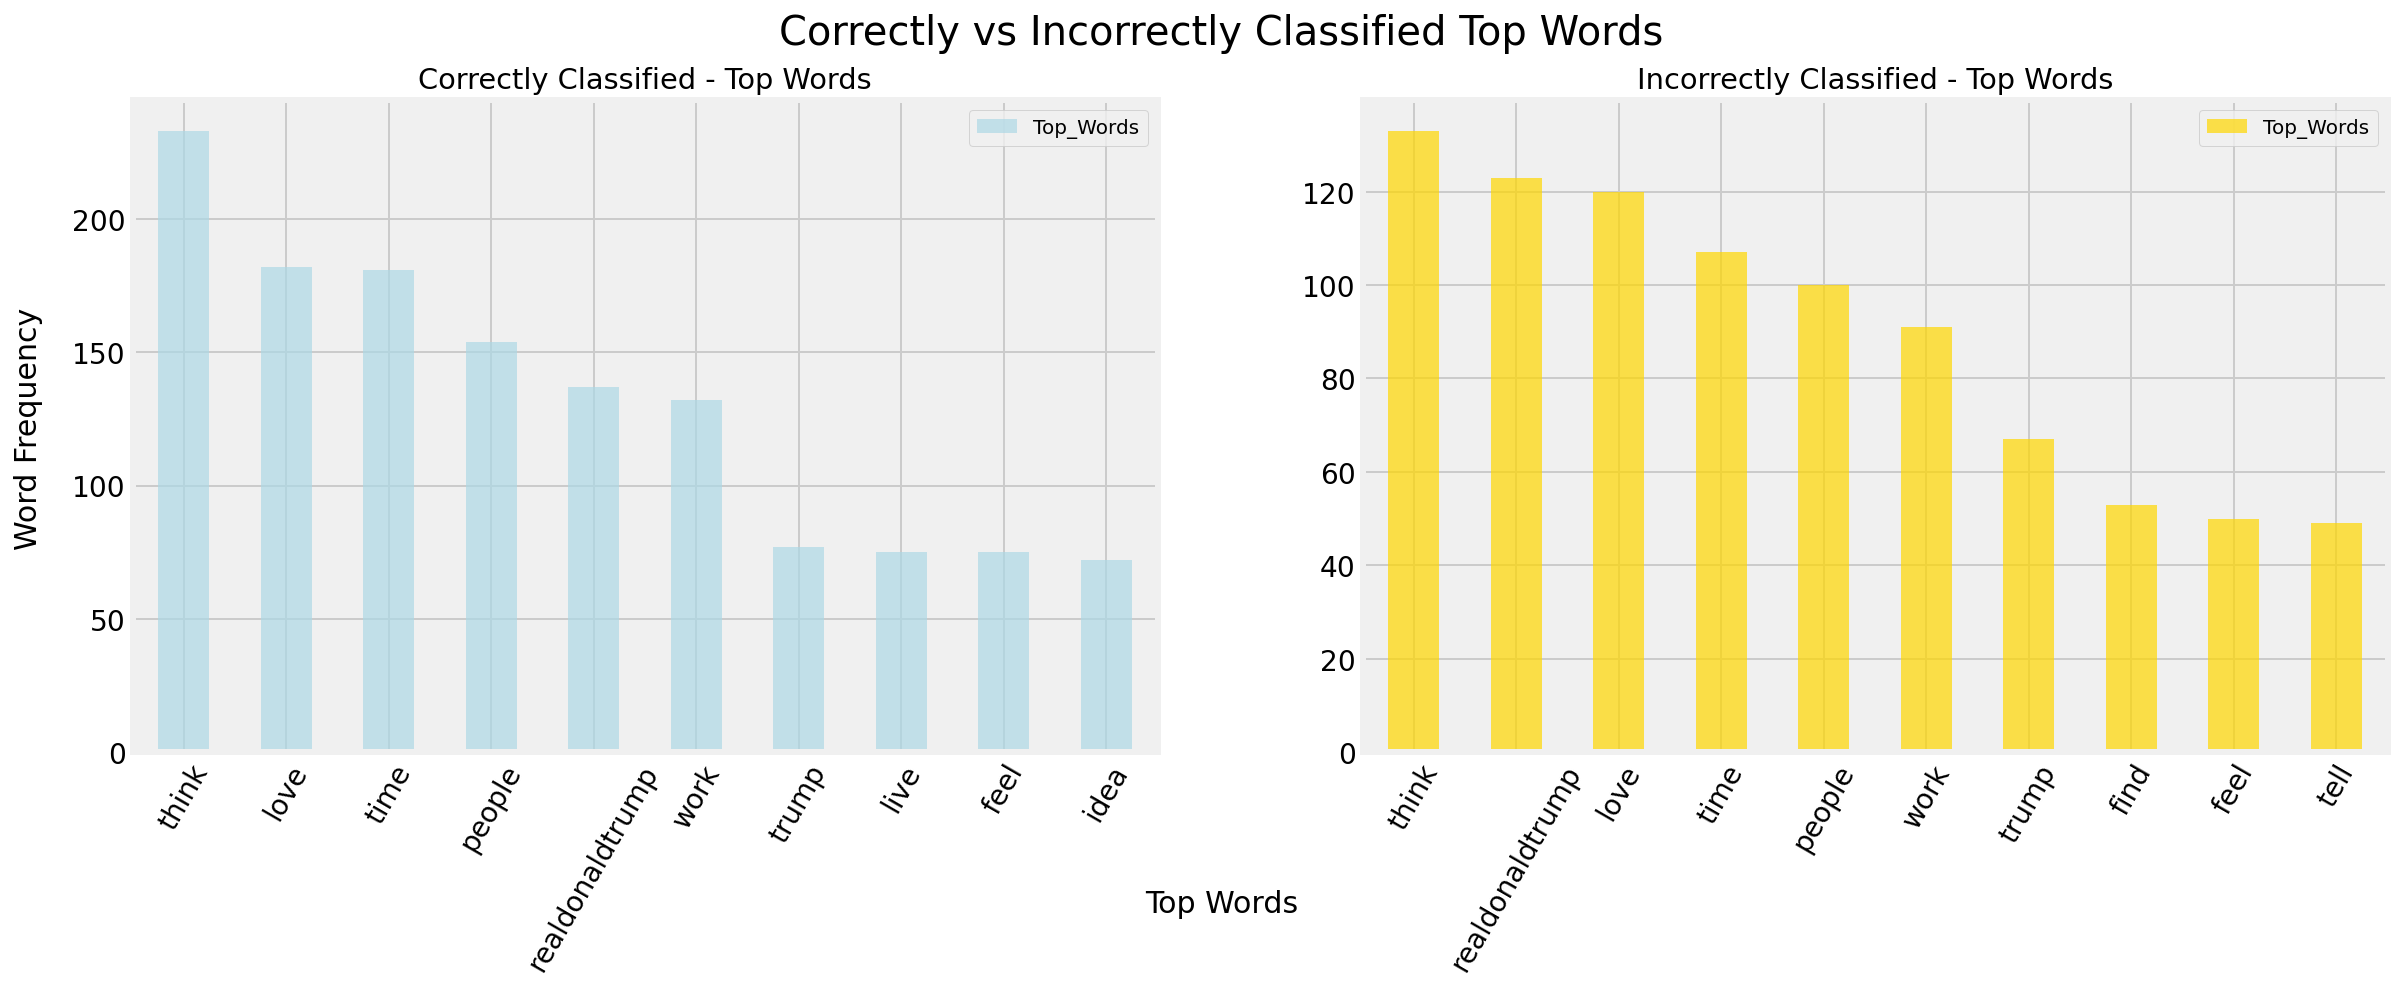

In [194]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ctwords.plot(kind='bar', ax=axes[0], title='Correctly Classified - Top Words',
                              color='Lightblue', alpha=.7, fontsize=14)
ictwords.plot(kind='bar', ax=axes[1], title='Incorrectly Classified - Top Words',
                              color='Gold', alpha=.7, fontsize=14)
fig.suptitle('Correctly vs Incorrectly Classified Top Words', fontsize=20)
# ax.set_xlabel('xlabel', fontsize=10)
# plt.ylabel('ylabel', fontsize=16)

# Set common labels
fig.text(0.5, -.05, 'Top Words', ha='center', va='center', fontsize=15)
fig.text(0.04, 0.5, 'Word Frequency', ha='center', va='center', rotation='vertical', fontsize=15)
axes[0].tick_params(axis='x', rotation=60)
axes[1].tick_params(axis='x', rotation=60)



It makes sense that the classifier would have trouble discerning the difference between tweets. There is a lot of overlap in correctly vs incorrectly classified tweets. Furthmore, it seems realdonaldtrump tweets (RIP) were especially deceptive.

# Appendix

32868
9034
['kroosh', 'dick', 'stephenfhayes', 'play', 'patsy']


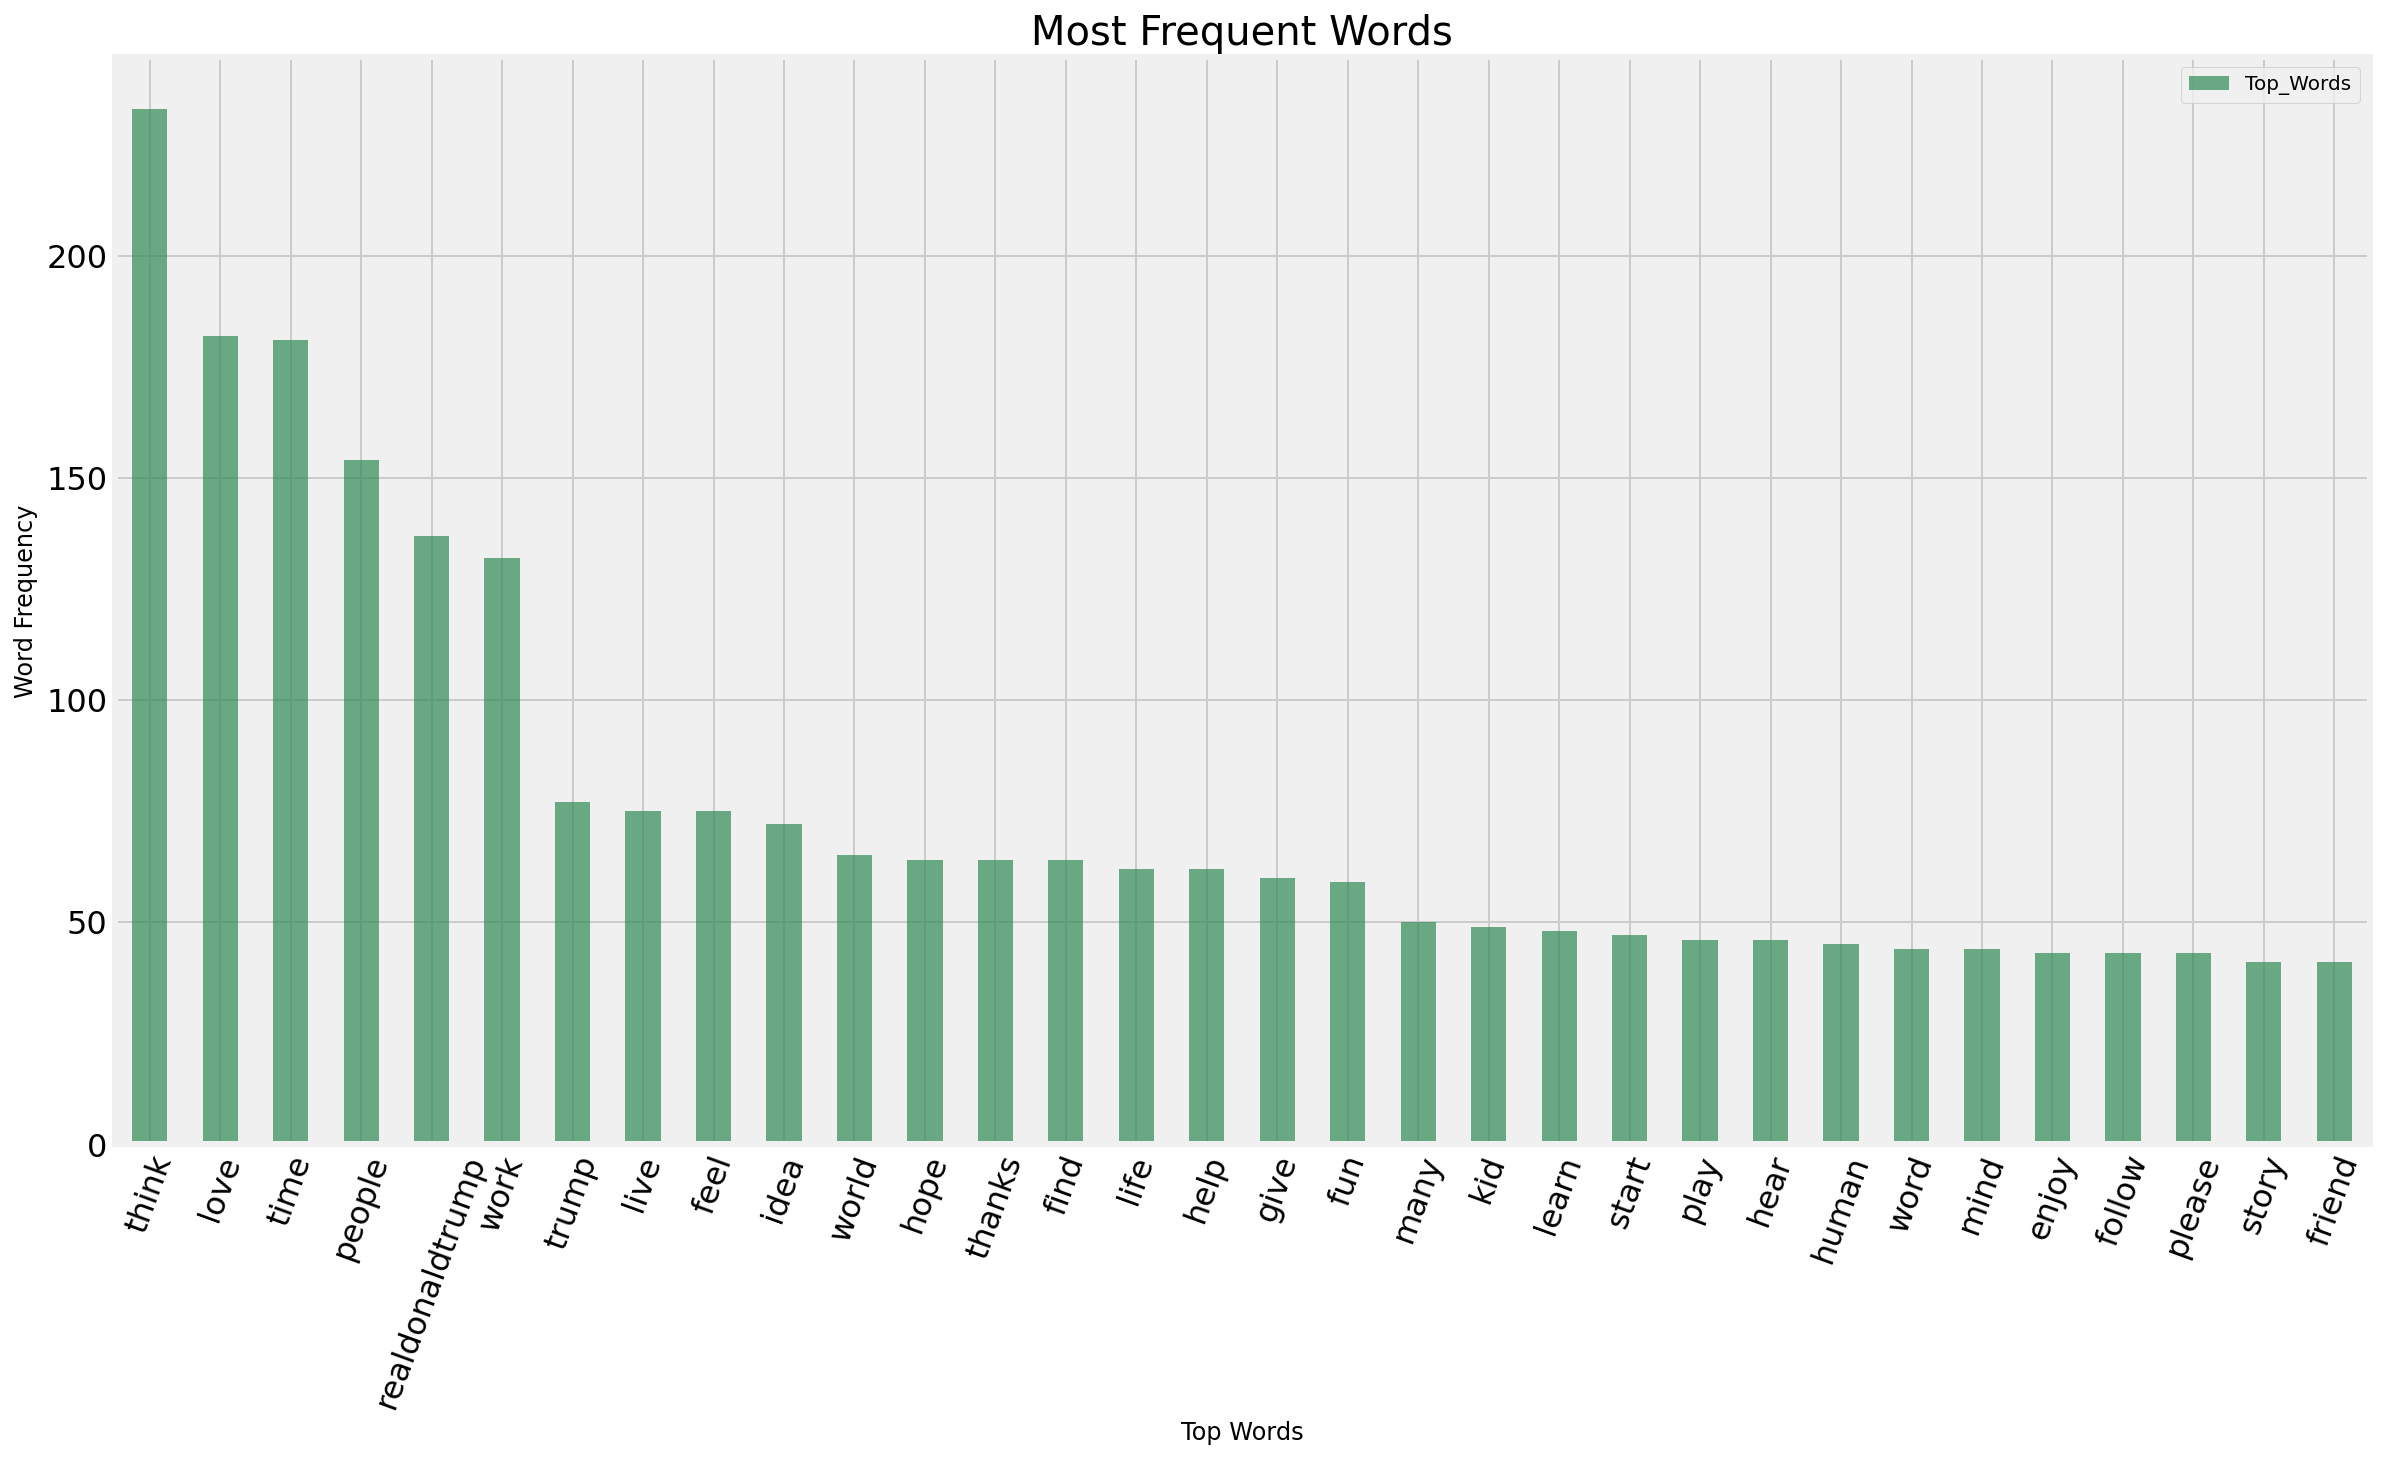

In [124]:
clean_dist(corrected)

21625
7081
['yikes', 'australia', 'body', 'find', 'one']


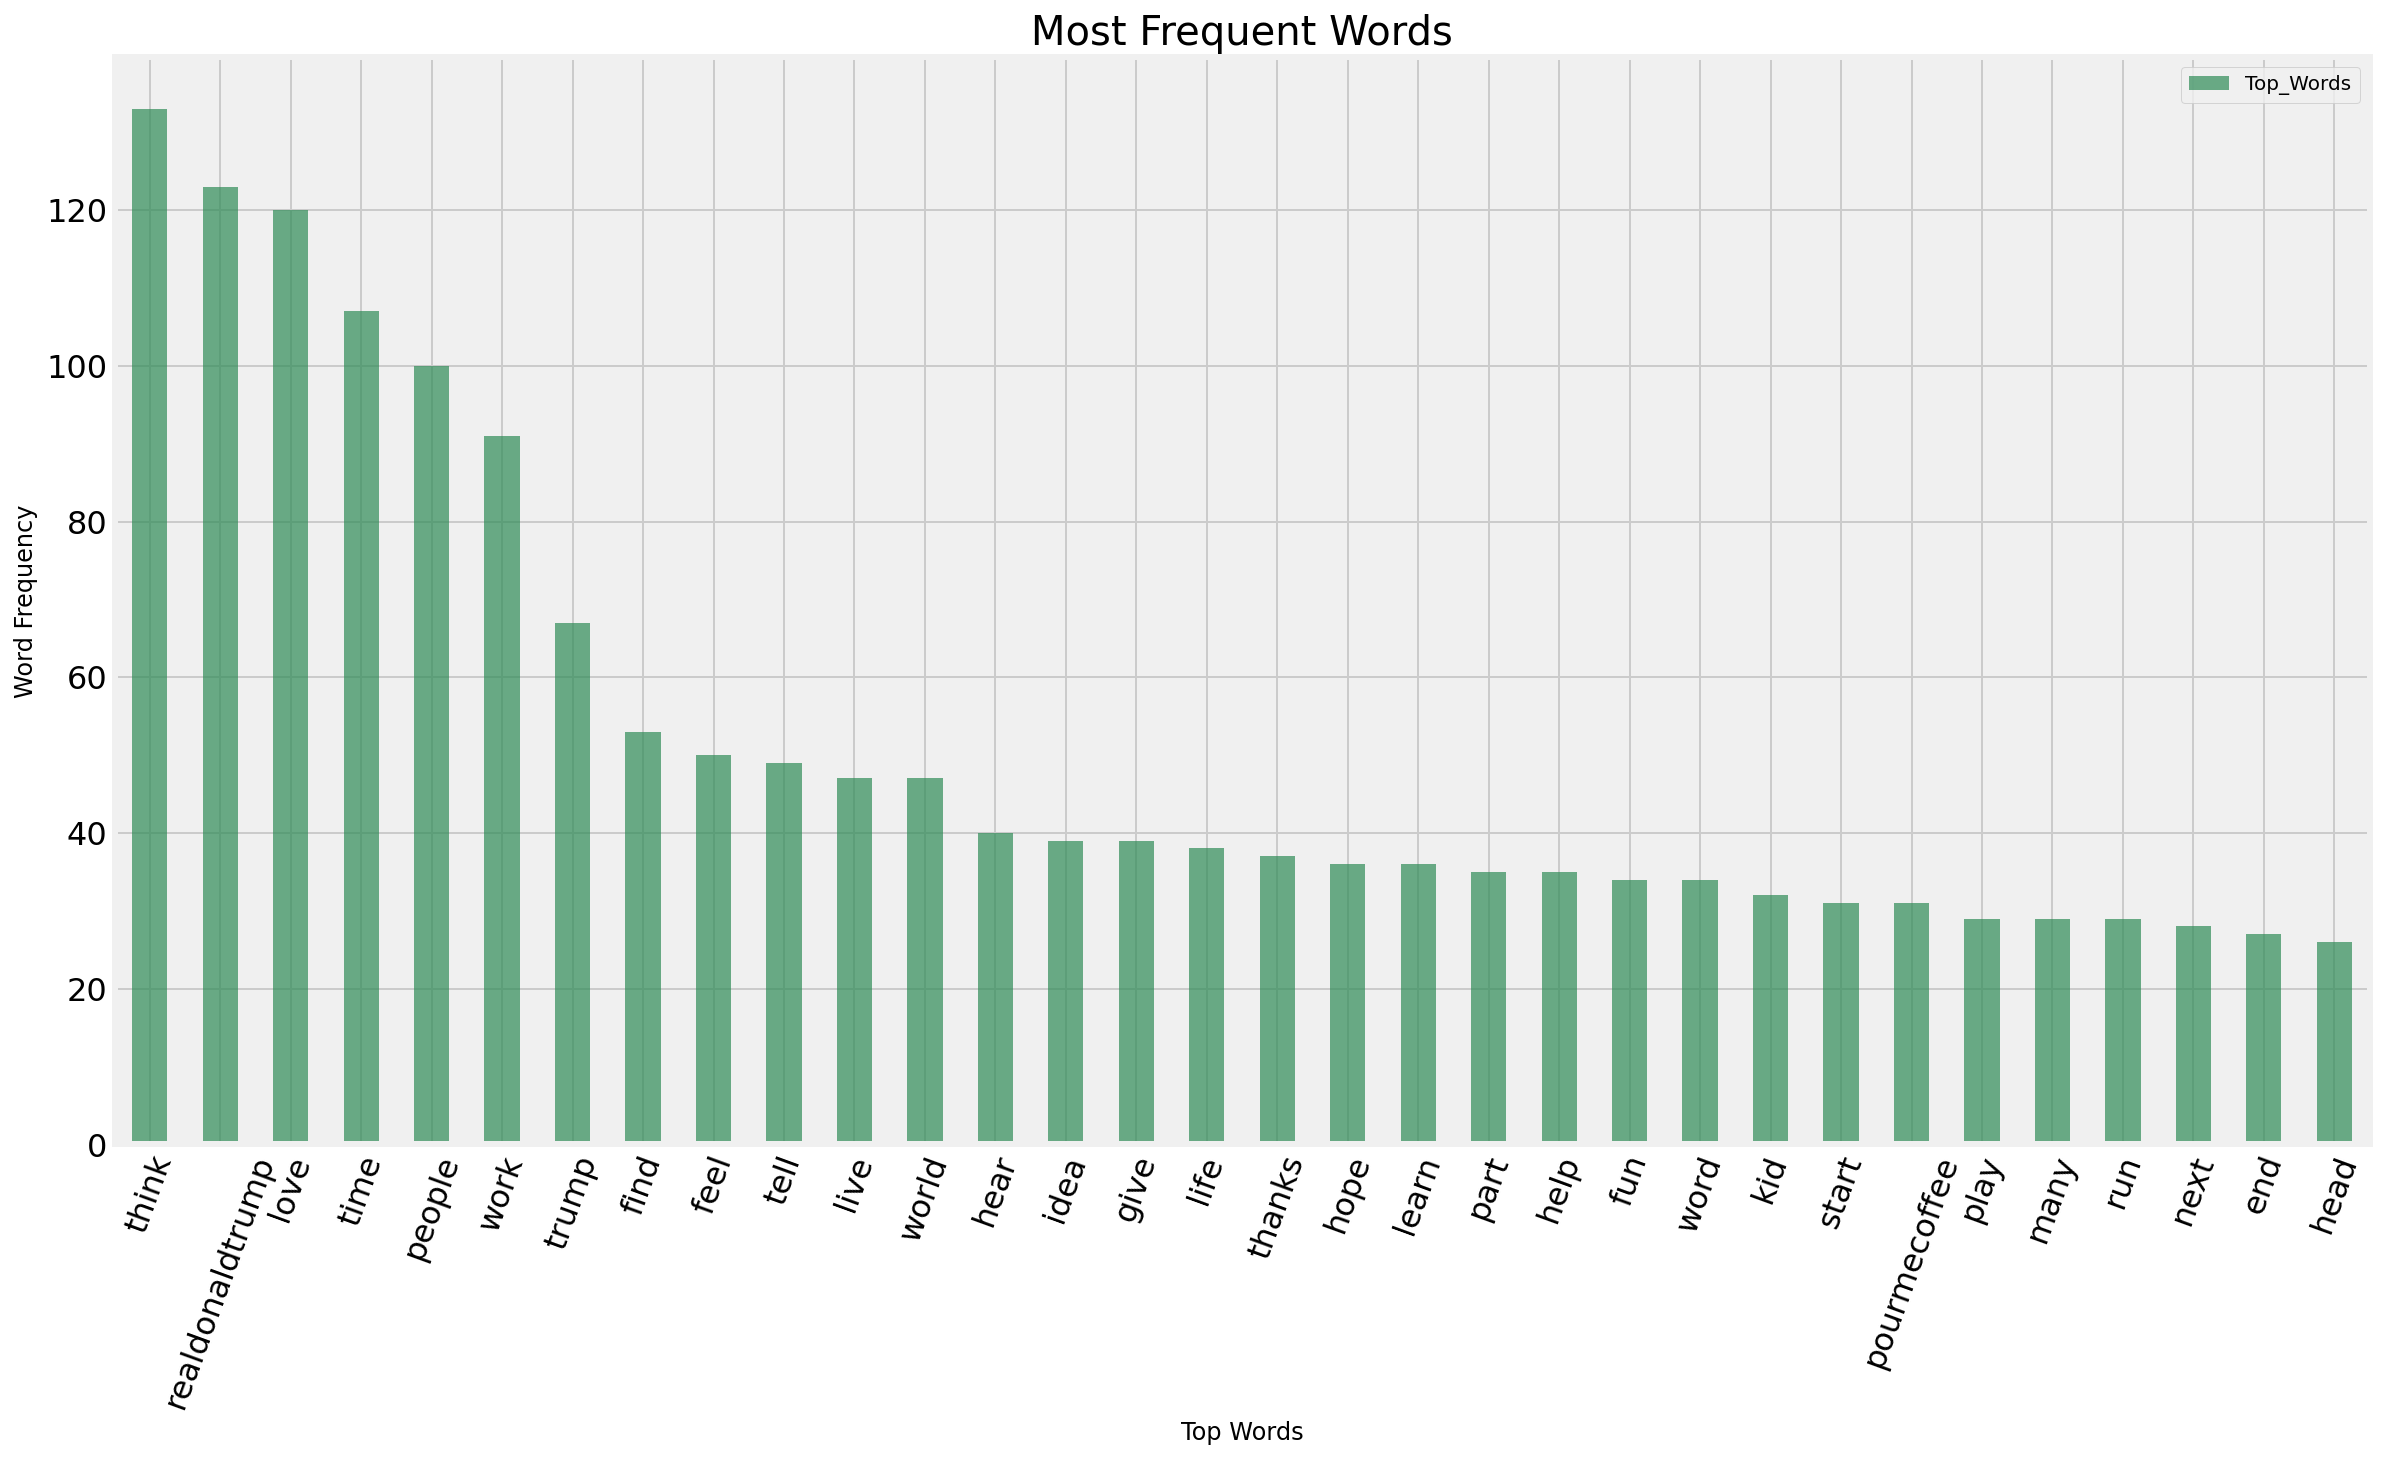

In [136]:
cleaner(incorrected, 'tweet_clean')
incorrected['preproc_pipe'] = preprocess_pipe(incorrected['clean'])
clean_dist(incorrected)